## Necessary imports

Main dependencies:

* tensorflow 1.x for neural networks
* matplotlib for visualization
* pandas for data manipulation

In [168]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
import os
import plotly
import plotly.graph_objs as go
import time
import itertools
import cv2
import seaborn as sns
import warnings
import tqdm
import math
from PIL import Image

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
plotly.offline.init_notebook_mode(True)

#dataset_dir = '../input/'
dataset_dir = ''
meta_info = os.path.join(dataset_dir, 'Meta.csv')
train_csv_path = os.path.join(dataset_dir, 'Train.csv')
test_csv_path = os.path.join(dataset_dir, 'Test.csv')
labels = ['20 km/h', '30 km/h', '50 km/h', '60 km/h', '70 km/h', '80 km/h', '80 km/h end', '100 km/h', '120 km/h', 'No overtaking',
               'No overtaking for tracks', 'Crossroad with secondary way', 'Main road', 'Give way', 'Stop', 'Road up', 'Road up for track', 'Brock',
               'Other dangerous', 'Turn left', 'Turn right', 'Winding road', 'Hollow road', 'Slippery road', 'Narrowing road', 'Roadwork', 'Traffic light',
               'Pedestrian', 'Children', 'Bike', 'Snow', 'Deer', 'End of the limits', 'Only right', 'Only left', 'Only straight', 'Only straight and right', 
               'Only straight and left', 'Take right', 'Take left', 'Circle crossroad', 'End of overtaking limit', 'End of overtaking limit for track']

### Load data
We should remap path because of kaggle converts folder to lowercase mode

In [132]:
train_data_color = '#0f7b8e'
test_data_color = '#630f8e'

INPUT_SIZE = 30

trainDf = pd.read_csv(train_csv_path)
testDf = pd.read_csv(test_csv_path)
metaDf = pd.read_csv(meta_info)

trainDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x.lower()), trainDf['Path']))
testDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x.lower()), testDf['Path']))
metaDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x.lower()), metaDf['Path']))

trainDf.sample(3)

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
32331     58      54       5       6      53      49       31   
20871     68      61       6       6      62      56       13   
2791      35      31       5       5      30      26        2   

                                 Path  
32331  train/31/00031_00008_00021.png  
20871  train/13/00013_00013_00021.png  
2791    train/2/00002_00000_00001.png

### Discover dataset balance
The easiest way to discover dataset balance - build histogram. We consider to use [seaborn](https://seaborn.pydata.org/) library based on matplotlib for pretty data visualization.

Train and test subset of dataset have similar balance distribution. Train and test split provided by GTSRB.

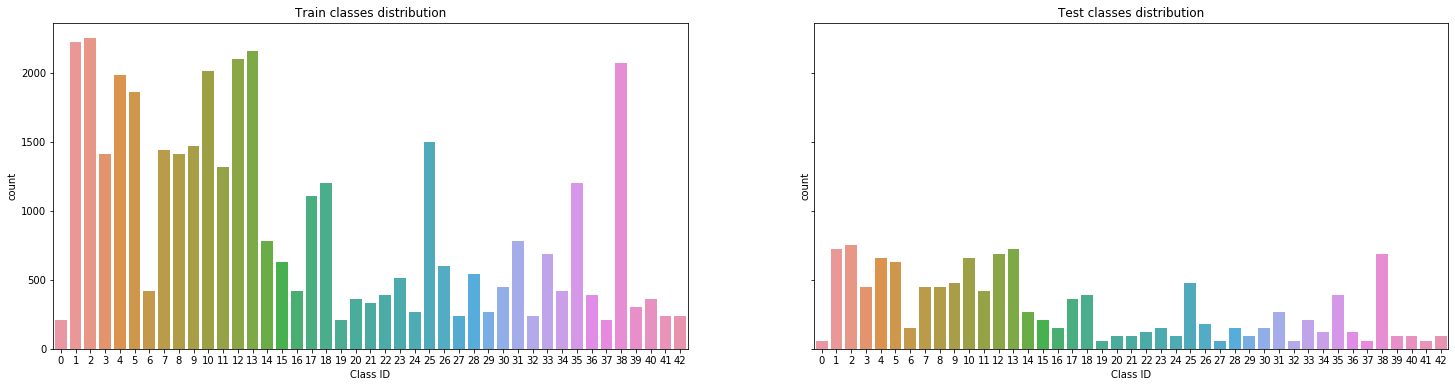

In [53]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(25, 6))
axs[0].set_title('Train classes distribution')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')
axs[1].set_title('Test classes distribution')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Count')

sns.countplot(trainDf.ClassId, ax=axs[0])
sns.countplot(testDf.ClassId, ax=axs[1])
axs[0].set_xlabel('Class ID');
axs[1].set_xlabel('Class ID');

### Image size distribution
Dataset contains thouthands of images. Images don't have the same resolution. Some of them are big, other are small. We should somehow choose appropriate resolution of samples. The best way to visualize width and height corellation - using multivariate plotting.

As we can see bellow, most of images is rectangular (it can be prooved by applying liniar regression on the samples resolution). Most of samples are about 35x35 pixels. And only few samples have big resolution like a 100x100 pixels.

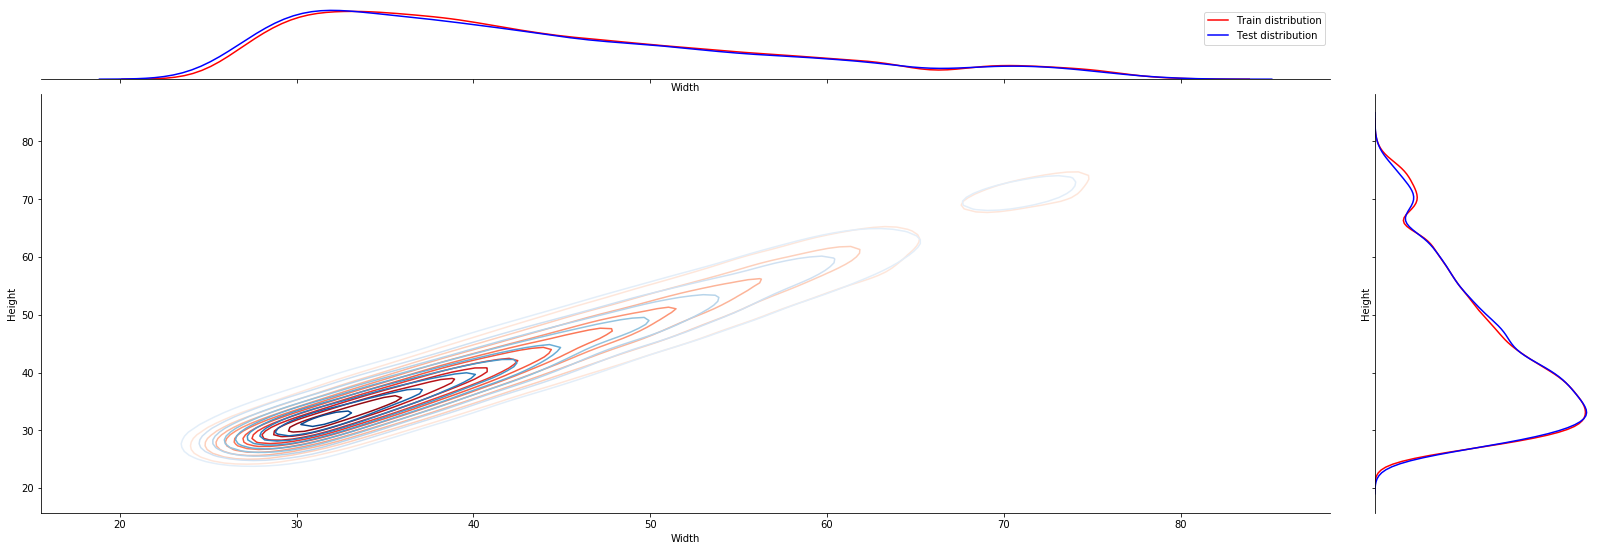

In [54]:
trainDfDpiSubset = trainDf[(trainDf.Width < 80) & (trainDf.Height < 80)];
testDfDpiSubset = testDf[(testDf.Width < 80) & (testDf.Height < 80)];

g = sns.JointGrid(x="Width", y="Height", data=trainDfDpiSubset)
sns.kdeplot(trainDfDpiSubset.Width, trainDfDpiSubset.Height, cmap="Reds",
        shade=False, shade_lowest=False, ax=g.ax_joint)
sns.kdeplot(testDfDpiSubset.Width, testDfDpiSubset.Height, cmap="Blues",
        shade=False, shade_lowest=False, ax=g.ax_joint)
sns.distplot(trainDfDpiSubset.Width, kde=True, hist=False, color="r", ax=g.ax_marg_x, label='Train distribution')
sns.distplot(testDfDpiSubset.Width, kde=True, hist=False, color="b", ax=g.ax_marg_x, label='Test distribution')
sns.distplot(trainDfDpiSubset.Width, kde=True, hist=False, color="r", ax=g.ax_marg_y, vertical=True)
sns.distplot(testDfDpiSubset.Height, kde=True, hist=False, color="b", ax=g.ax_marg_y, vertical=True)
g.fig.set_figwidth(25)
g.fig.set_figheight(8)
plt.show();

### Target class visualization
It is not a sample in the dataset, it is just a picture of sign. Some of them may be different from the dataset samples because of dataset contains images of German traffic signs and pictures bellow are Ukrainian traffic signs ([source of pictures](http://pdd.ua/33/))

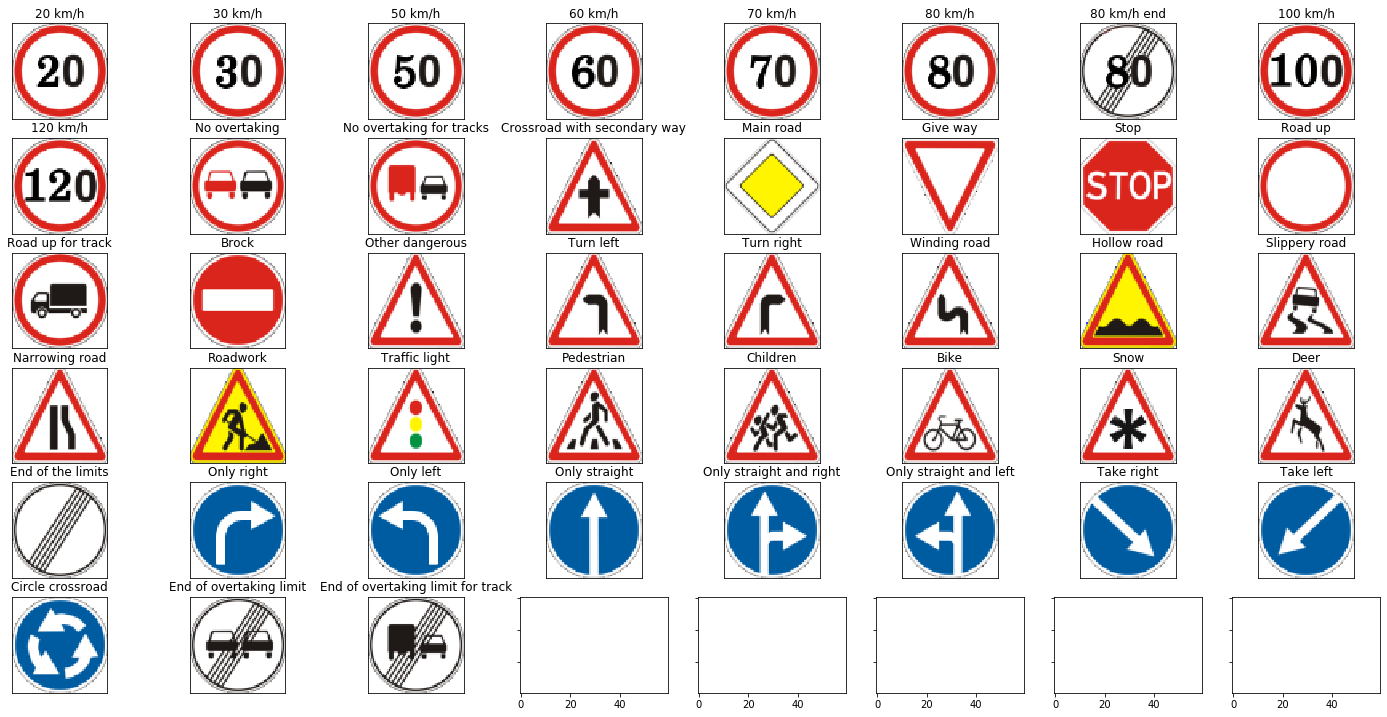

In [55]:
sns.set_style()
rows = 6
cols = 8
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=None)
metaDf = metaDf.sort_values(by=['ClassId'])

idx = 0
for i in range(rows):
    for j in range(cols):
        if idx > 42:
            break
            
        img = cv2.imread(metaDf["Path"].tolist()[idx], cv2.IMREAD_UNCHANGED)
        img[np.where(img[:,:,3]==0)] = [255,255,255,255]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (INPUT_SIZE,INPUT_SIZE))
        
        axs[i,j].imshow(img)
        axs[i,j].set_facecolor('xkcd:salmon')
        axs[i,j].set_facecolor((1.0, 0.47, 0.42))
        axs[i,j].set_title(labels[int(metaDf["ClassId"].tolist()[idx])])
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1

### Samples visualization

It is good idea to visualize samples in order to brief data exploration. Image visualization can help to understand data problem. Some solutions (such as histogram equalization) can be discovered by visual data exploration

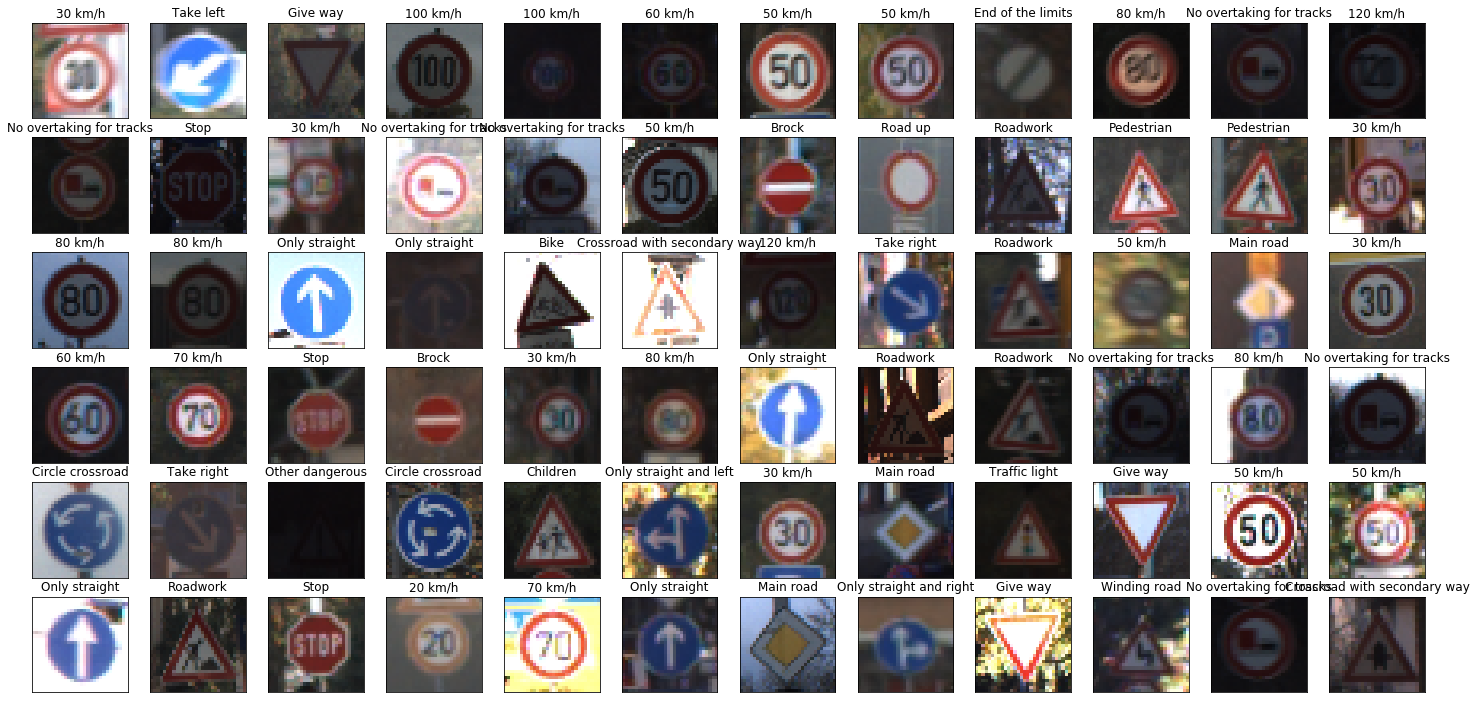

In [129]:
rows = 6
cols = 8+4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=None)
visualize = trainDf.sample(rows*cols)

idx = 0
for i in range(rows):
    for j in range(cols):
        img = cv2.imread(visualize["Path"].tolist()[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (INPUT_SIZE,INPUT_SIZE))
        axs[i,j].imshow(img)
        axs[i,j].set_title(labels[int(visualize["ClassId"].tolist()[idx])])
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1

### Tensorflow utils

We decide to use native tensorflow as deep learning framework without high level API. The best way to implement data pipleline - implement load data operation as node of comoutition graph. This will be the first node of computitional graph (i.e. all other node is depended from it). This approach has several adantages:

- Parallelism out of the box (provided by dataflow graph principies)
- Opportunity to implement data augmentation on GPU (not implemented here)
- Convenient way to wrok with it provided by tf.data infrastructure
- Fast way to use native and 3rd party python libraries wrapped by tf.py_func (deprecated since 1.13.? version)

Here we defined utils for loading tensors, augmentation and other data manipulation

In [169]:
img_load_size = (INPUT_SIZE,INPUT_SIZE)
zero_img = np.zeros([12,img_load_size[0], img_load_size[1], 3])
zero_label = np.zeros([12,1])

# def parse_function(filename, label):
#         image_string = tf.read_file(filename)
#         image = tf.image.decode_jpeg(image_string, channels=3)
# #         image = tf.py_func(eq, [image], image.dtype)
#         image.set_shape([None, None, 3])
        
#         return filename, image, label
    
# def train_preprocess(filename, image, label):
#     image = tf.image.convert_image_dtype(image, tf.float32)
#     image = tf.image.resize_images(image, img_load_size)
#     return filename, image, label

# def augmentate(filename, image, label):
#     grad = tf.random.uniform(shape=[], minval=-0.3, maxval=0.3)
#     dx = tf.random.uniform(shape=[], minval=-15, maxval=15, dtype=tf.int32)
#     dy = tf.random.uniform(shape=[], minval=-15, maxval=15, dtype=tf.int32)
#     image = tf.contrib.image.rotate(image, grad)
#     image = tf.contrib.image.translate(image, translations=[dx, dy])
    
#     return filename, image, label

# def eq(img: np.ndarray):
#     res = img.copy()
#     res[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
#     res[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
#     res[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    
#     return res

# def tf_equalize_histogram(image):
#     values_range = tf.constant([0., 255.], dtype = tf.float32)
#     histogram = tf.histogram_fixed_width(tf.to_float(image), values_range, 256)
#     cdf = tf.cumsum(histogram)
#     cdf_min = cdf[tf.reduce_min(tf.where(tf.greater(cdf, 0)))]

#     img_shape = tf.shape(image)
#     pix_cnt = img_shape[-3] * img_shape[-2]
#     px_map = tf.round(tf.to_float(cdf - cdf_min) * 255. / tf.to_float(pix_cnt - 1))
#     px_map = tf.cast(px_map, tf.uint8)

#     gth = tf.gather_nd(px_map, tf.cast(image, tf.int32))
#     eq_hist = tf.expand_dims(gth, 2)
#     return image

### Tensorflow data pipeline

Above we have prepared pandas DataFrame with all data. Now, let's create operaition for loading data using [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [218]:
from scipy import ndimage
def augment_image(image):
    max_n = 15
    min_n = -15
    noise_add = np.random.uniform(min_n, max_n, image.shape)
    rotate_add = np.random.uniform(min_n, max_n)
    trans_x = np.random.uniform(5, 5)
    trans_y = np.random.uniform(5, 5)
#     print(rotate_add)

    #add noise to image
    noisy_img = np.add(image,noise_add)
    image = np.clip(noisy_img, 0, 255)
    image = np.int_(image)

    #rotation
    image = ndimage.rotate(image, rotate_add,reshape=False)
    #tanslation
    image = ndimage.shift(image,(trans_x,trans_y,0))

    return image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


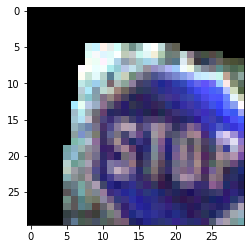

In [219]:
#test

image = cv2.imread('./pi_image/2.png')
image = cv2.resize(image, (INPUT_SIZE,INPUT_SIZE))
image = augment_image(image)

plt.imshow(image)
plt.show()

In [221]:
from scipy import ndimage
# Reading the input images and putting them into a numpy array
data=[]
labels=[]

height = 60
width = 60
channels = 3
classes = 1
n_inputs = height * width*channels

for i in range(classes) :
    path = "./train/{0}/".format(i)
    print(path)
    Class=os.listdir(path)
    for a in Class:
        try:
            image=cv2.imread(path+a)
            image_from_array = Image.fromarray(image, 'RGB')
            size_image = image_from_array.resize((height, width))
            data.append(np.array(size_image))
            labels.append(i)
            size_image = augment_image(size_image)
            data.append(np.array(size_image))
            labels.append(i)
        except AttributeError:
            print(" ")
            
        
Cells=np.array(data)
labels=np.array(labels)

#Randomize the order of the input images
s=np.arange(Cells.shape[0])
np.random.seed(43)
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

./train/0/
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 


In [212]:
for i in Cells:
    print(i.shape)

(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60, 60, 3)
(60,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


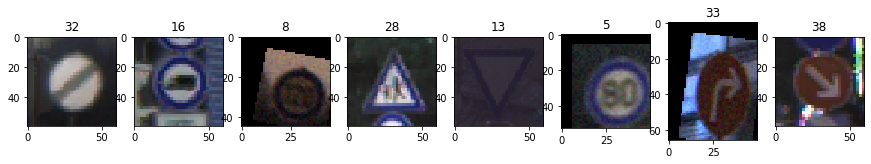

In [186]:
fig, ax = plt.subplots(ncols=8, nrows=1, figsize=(15, 6))
for j in range(8):
    i = Cells[j]
    ax[j].imshow(i)
    ax[j].set_title(labels[j])
# with tf.Session() as sess:
#     sess.run(train_init_op)
#     for j in range(8):
#         i, l = sess.run([load_img, load_label])
#         i = (i[0]*255).astype(np.uint8)
#         ax[j].imshow(i)
#         ax[j].set_title(labels[l[0]])

### Model definition

Model graph defined using native tensorflow API. Also, we should defined some placeholders in order to have opportunity to load custom controled data into netwrok (for further model analysis)

In [187]:
#Definition of the DNN model

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(30,30,3)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

#Compilation of the model
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [49]:
# dp_rate = tf.placeholder(dtype=tf.float32, shape=[], name='dp_rate')

# img_placeholder = tf.placeholder(shape=[None, 60,60,3], dtype=tf.float32, name='img_placeholder')
# label_placeholder = tf.placeholder(shape=[None, 1], dtype=tf.int64, name='label_placeholder')
# manual_load = tf.placeholder(dtype=tf.bool, shape=[], name='manual_load_placeholder')

# # inp = net = tf.cond(pred=manual_load, true_fn=lambda : img_placeholder, false_fn=lambda : load_img, name='network_start')
# # label = tf.cond(pred=manual_load, true_fn=lambda : label_placeholder, false_fn=lambda : load_label, name='label')

# inp = net = tf.cond(manual_load, lambda: img_placeholder, lambda: load_img)
# label = load_label

# conv1 = net = tf.layers.conv2d(inputs=net, filters=16, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
# net = tf.layers.batch_normalization(inputs=net)
# conv2 = net = tf.layers.conv2d(inputs=net, filters=32, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
# net = tf.layers.batch_normalization(inputs=net)

# conv3 = net = tf.layers.conv2d(inputs=net, filters=32, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
# net = tf.layers.batch_normalization(inputs=net)
# conv4 = net = tf.layers.conv2d(inputs=net, filters=64, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
# net = tf.layers.batch_normalization(inputs=net)

# net = tf.layers.max_pooling2d(inputs=net, pool_size=(2,2), strides=(2,2))

# conv5 = net = tf.layers.conv2d(inputs=net, filters=64, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
# net = tf.layers.batch_normalization(inputs=net)
# conv6 = net = tf.layers.conv2d(inputs=net, filters=128, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
# net = tf.layers.batch_normalization(inputs=net)

# conv5 = net = tf.layers.conv2d(inputs=net, filters=256, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
# net = tf.layers.batch_normalization(inputs=net)
# conv6 = net = tf.layers.conv2d(inputs=net, filters=400, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
# net = tf.layers.batch_normalization(inputs=net)

# flatten1 = net = tf.layers.flatten(inputs=net)

# dp1 = net = tf.layers.dropout(inputs=net, rate=dp_rate)
# dense1 = net = tf.layers.dense(inputs=net, units=256)
# logits = tf.layers.dense(inputs=net, units=43)

# pred_classes = tf.argmax(logits, axis=1)
# pred_probas = tf.nn.softmax(logits)

# acc, acc_op = tf.metrics.accuracy(labels=label, predictions=pred_classes)
# end_loss = tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=label)

# loss = end_loss

# label_transpose = tf.transpose(label)
# correct_prediction = tf.equal(pred_classes, label_transpose)
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# confusion_matrix_op = tf.confusion_matrix(labels=label, predictions=pred_classes, num_classes=43)

# opt = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

### Model training

Train model several epoch and store results of each epoch for further analysis

In [71]:
# with tf.device('/gpu:0'):
#     a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
#     b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
#     c = tf.matmul(a, b)

# with tf.Session() as sess:
#     print (sess.run(c))

In [ ]:
#using ten epochs for the training and saving the accuracy for each epoch
epochs = 10
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs,
validation_data=(X_val, y_val))

In [30]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
sess = tf.Session(config=config)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
# irn.load_weights('inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5')
train_history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
best_acc = 0

for e in range(epochs):
    epoch_history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
    
    sess.run(train_init_op)
    for i in tqdm.tqdm_notebook(range(samples_train//batch_size), ascii=True, desc='Train epoch {}'.format(e)):
        _, _loss, _acc, mn = sess.run([opt, loss, accuracy, inp], feed_dict={dp_rate: 0.3, manual_load: False, img_placeholder: zero_img, label_placeholder: zero_label})
#         print(np.mean(mn))
        epoch_history['loss'].append(_loss)
        epoch_history['acc'].append(_acc)
        
    sess.run(test_init_op)
    for i in tqdm.tqdm_notebook(range(samples_test//batch_size), ascii=True, desc='Test epoch {}'.format(e)):
        _loss, _acc = sess.run([loss, accuracy], feed_dict={dp_rate: 0, manual_load: False, img_placeholder: zero_img, label_placeholder: zero_label})
        epoch_history['val_loss'].append(_loss)
        epoch_history['val_acc'].append(_acc)
        
    train_history['loss'].append(np.mean(epoch_history['loss']))
    train_history['acc'].append(np.mean(epoch_history['acc']))
    train_history['val_loss'].append(np.mean(epoch_history['val_loss']))
    train_history['val_acc'].append(np.mean(epoch_history['val_acc']))
    
    print("***EPOCH SUMMARY*** Loss: {} Acc: {} | Test Loss: {} Test Acc {}".format(train_history['loss'][-1], train_history['acc'][-1],
                                                                                    train_history['val_loss'][-1], train_history['val_acc'][-1]))

    if train_history['val_acc'][-1] > best_acc:
        best_acc = train_history['val_acc'][-1]
        save_path = saver.save(sess, "./model.ckpt")
        print("Model saved in path: %s" % save_path)


***EPOCH SUMMARY*** Loss: 2.1205620765686035 Acc: 0.36730945110321045 | Test Loss: 1.277623176574707 Test Acc 0.605354905128479
Model saved in path: ./model.ckpt



***EPOCH SUMMARY*** Loss: 0.7669652104377747 Acc: 0.7554841041564941 | Test Loss: 0.5583766102790833 Test Acc 0.8321451544761658
Model saved in path: ./model.ckpt



***EPOCH SUMMARY*** Loss: 0.33665692806243896 Acc: 0.8947811722755432 | Test Loss: 0.27160951495170593 Test Acc 0.9152407646179199
Model saved in path: ./model.ckpt



***EPOCH SUMMARY*** Loss: 0.21852970123291016 Acc: 0.9342159628868103 | Test Loss: 0.34453171491622925 Test Acc 0.9223700761795044
Model saved in path: ./model.ckpt



***EPOCH SUMMARY*** Loss: 0.16844885051250458 Acc: 0.948321521282196 | Test Loss: 0.2939116656780243 Test Acc 0.9407477974891663
Model saved in path: ./model.ckpt



***EPOCH SUMMARY*** Loss: 0.13666081428527832 Acc: 0.9592133164405823 | Test Loss: 0.18917325139045715 Test Acc 0.9496197700500488
Model saved in path: ./model.ckpt



***EPOCH SUMMARY*** Loss: 0.11630059033632278 Acc: 0.9662279486656189 | Test Loss: 0.2170564979314804 Test Acc 0.9597592949867249
Model saved in path: ./model.ckpt



***EPOCH SUMMARY*** Loss: 0.10565056651830673 Acc: 0.9700286388397217 | Test Loss: 0.19012458622455597 Test Acc 0.9671261310577393
Model saved in path: ./model.ckpt



***EPOCH SUMMARY*** Loss: 0.09591188281774521 Acc: 0.9730895161628723 | Test Loss: 0.17879927158355713 Test Acc 0.9631654024124146



***EPOCH SUMMARY*** Loss: 0.08912343531847 Acc: 0.9753851294517517 | Test Loss: 0.17681583762168884 Test Acc 0.9689480662345886
Model saved in path: ./model.ckpt


### Training result

It's good practice to visualize accuracy and loss evolution. [plotly](https://plot.ly/) library gives as way to build interactive figures inplace in jupyter

In [31]:
titlefont = dict(family='Courier New, monospace', size=18, color='#7f7f7f')
layout = go.Layout(title='Traing & Test loss', xaxis=dict(title='Epoch', titlefont=titlefont),
                                    yaxis=dict(title='Loss', titlefont=titlefont))
fig = go.Figure(data=[go.Scatter(y=train_history['loss'], name='Train loss'), go.Scatter(y=train_history['val_loss'], name='Test loss')], layout=layout)
plotly.offline.iplot(fig)

layout = go.Layout(title='Traing & Test accuracy', xaxis=dict(title='Epoch', titlefont=titlefont),
                                    yaxis=dict(title='Accuracy', titlefont=titlefont))
fig = go.Figure(data=[go.Scatter(y=train_history['acc'], name='Train accuracy'), go.Scatter(y=train_history['val_acc'], name='Test accuracy')], layout=layout)
plotly.offline.iplot(fig)

### Model performance data preparation

For futher model analysis we need some data. Very good solution - store all statistic data in pandas DataFrame data structure. Let's evaluate all test samples and store all information about prediction, probabilities and other information

In [13]:
saver.restore(sess, "./model.ckpt")
sess.run(test_init_op)
confusion_matrix = np.zeros([43,43])
test_analys = trainDf.copy()
predictions = []
probabilities = []
analys = []

for i in tqdm.tqdm_notebook(range(samples_test//batch_size), ascii=True, desc='Test best model'):
    _files, _predictions, _probas, _gts, _cm = sess.run([load_filename, pred_classes, pred_probas, load_label, confusion_matrix_op], feed_dict={dp_rate: 0, manual_load: False, img_placeholder: zero_img, label_placeholder: zero_label})
    confusion_matrix += _cm
    for i in range(batch_size):
        sample_info = {'image': _files[i].decode(), 'prediction': int(_predictions[i]), 'gt': int(_gts[i]), 'gt_probas': _probas[i][_gts[i]],
                       'prediction_probas': _probas[i][_predictions[i]], 'prediction_type': 'Correct' if _gts[i] == _predictions[i] else 'Wrong'}
        for cls_id, j in enumerate(_probas[i]):
            sample_info['prob_{}'.format(cls_id)] = j
        analys.append(sample_info)

analys_df = pd.DataFrame(analys)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model.ckpt


### Model evaluation analys overview

We have built pandas DataFrame. Let's observe it structure

In [14]:
analys_df.sample(4)

gt  gt_probas           image  prediction  prediction_probas  \
110     1   0.999998  test/07908.png           1           0.999998   
10621   3   1.000000  test/08823.png           3           1.000000   
9521   10   0.999999  test/00538.png          10           0.999999   
2873   28   1.000000  test/02738.png          28           1.000000   

      prediction_type        prob_0        prob_1       prob_10       prob_11  \
110           Correct  5.632274e-09  9.999983e-01  9.120560e-23  1.159723e-20   
10621         Correct  2.057368e-16  5.499346e-20  1.469675e-20  1.769839e-22   
9521          Correct  1.547418e-22  3.894714e-19  9.999993e-01  8.120305e-14   
2873          Correct  3.060772e-23  2.129028e-29  0.000000e+00  8.731474e-24   

       ...       prob_39        prob_4       prob_40       prob_41  \
110    ...  1.995335e-18  1.616664e-06  1.492985e-16  7.173336e-20   
10621  ...  4.650598e-28  6.882858e-25  4.979560e-25  2.653872e-25   
9521   ...  7.676246e-23  3.399684e-21  6.880943e-23  1.464504e-19   
2873   ...  0.000000e+00  0.000000e+00  7.602213e-36  2.849983e-31   

            prob_42        prob_5        prob_6        prob_7        prob_8  \
110    1.157814e-19  2.594030e-12  9.175739e-14  1.002861e-13  6.714520e-15   
10621  2.756049e-29  5.815998e-15  2.647168e-14  6.867923e-28  2.631278e-20   
9521   9.781692e-16  2.295375e-14  4.126640e-17  7.665585e-18  3.578946e-17   
2873   0.000000e+00  2.594724e-29  1.100899e-29  0.000000e+00  3.468712e-35   

             prob_9  
110    5.229699e-20  
10621  4.372734e-21  
9521   1.827162e-14  
2873   4.456895e-32  

[4 rows x 49 columns]

### Random prediction visualization

Using information computed above, we can visualize some random samples with their predictions. As we can see - it is impossible to recognize some pictures definitely by human, but network still generates correct predictions. Awesome!

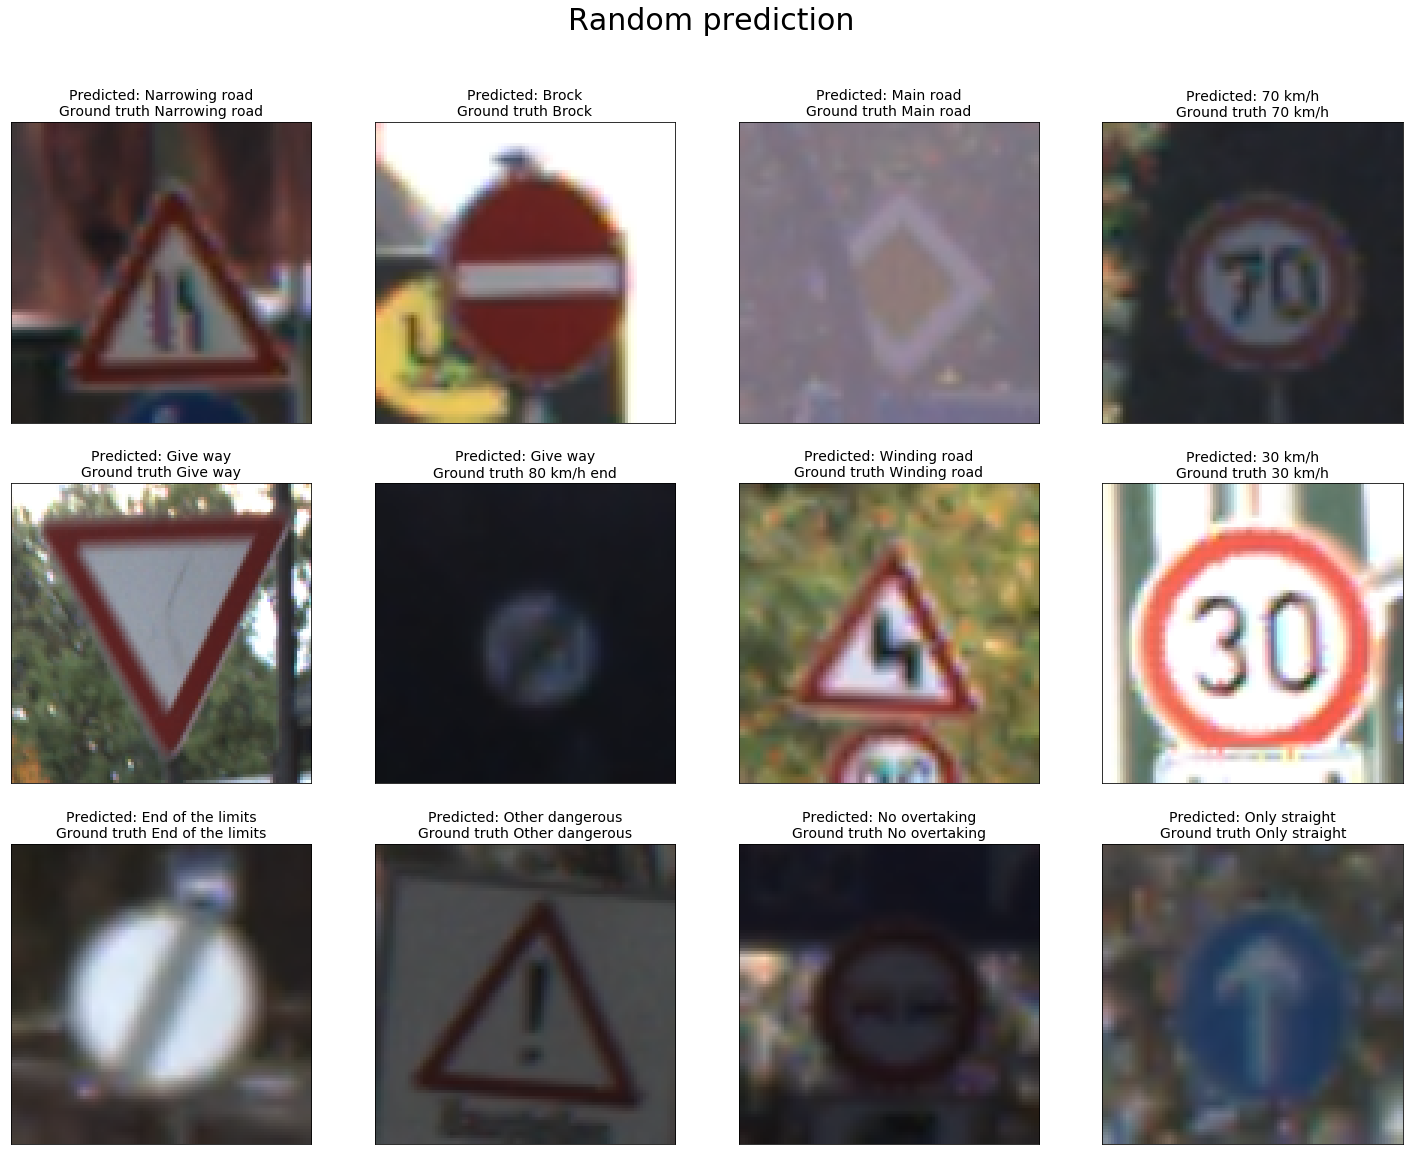

In [15]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 8))
visualize = trainDf.sample(rows*cols)

analys_df_copy = analys_df.copy()
analys_df_copy = analys_df_copy.sample(frac=1)

idx = 0
for i in range(rows):
    for j in range(cols):
        img = cv2.imread(analys_df_copy.iloc[idx]['image'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100, 100))
        
        gt = analys_df_copy.iloc[idx]['gt']
        pred = analys_df_copy.iloc[idx]['prediction']
        
        axs[i,j].imshow(img)
        axs[i,j].set_title('Predicted: {}\nGround truth {}'.format(labels[pred], labels[gt]), fontsize=14)
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1
        
fig.suptitle("Random prediction", fontsize=30, y=2.1, x=0.515);
plt.subplots_adjust(left=None, bottom=None, right=0.9, top=1.9, wspace=None, hspace=None)

### Wrong prediction visualization

Our model can't achieve perfect accuracy (i.e. 100%). Let's visualize wrong predicted samples. Some of them have realy bad quality, resolution. Others have unexpected artifacts (such as extreame rotation, half hidden signs or shaddow). This situations wasn't present in train part, so network have no idea how to deal with it

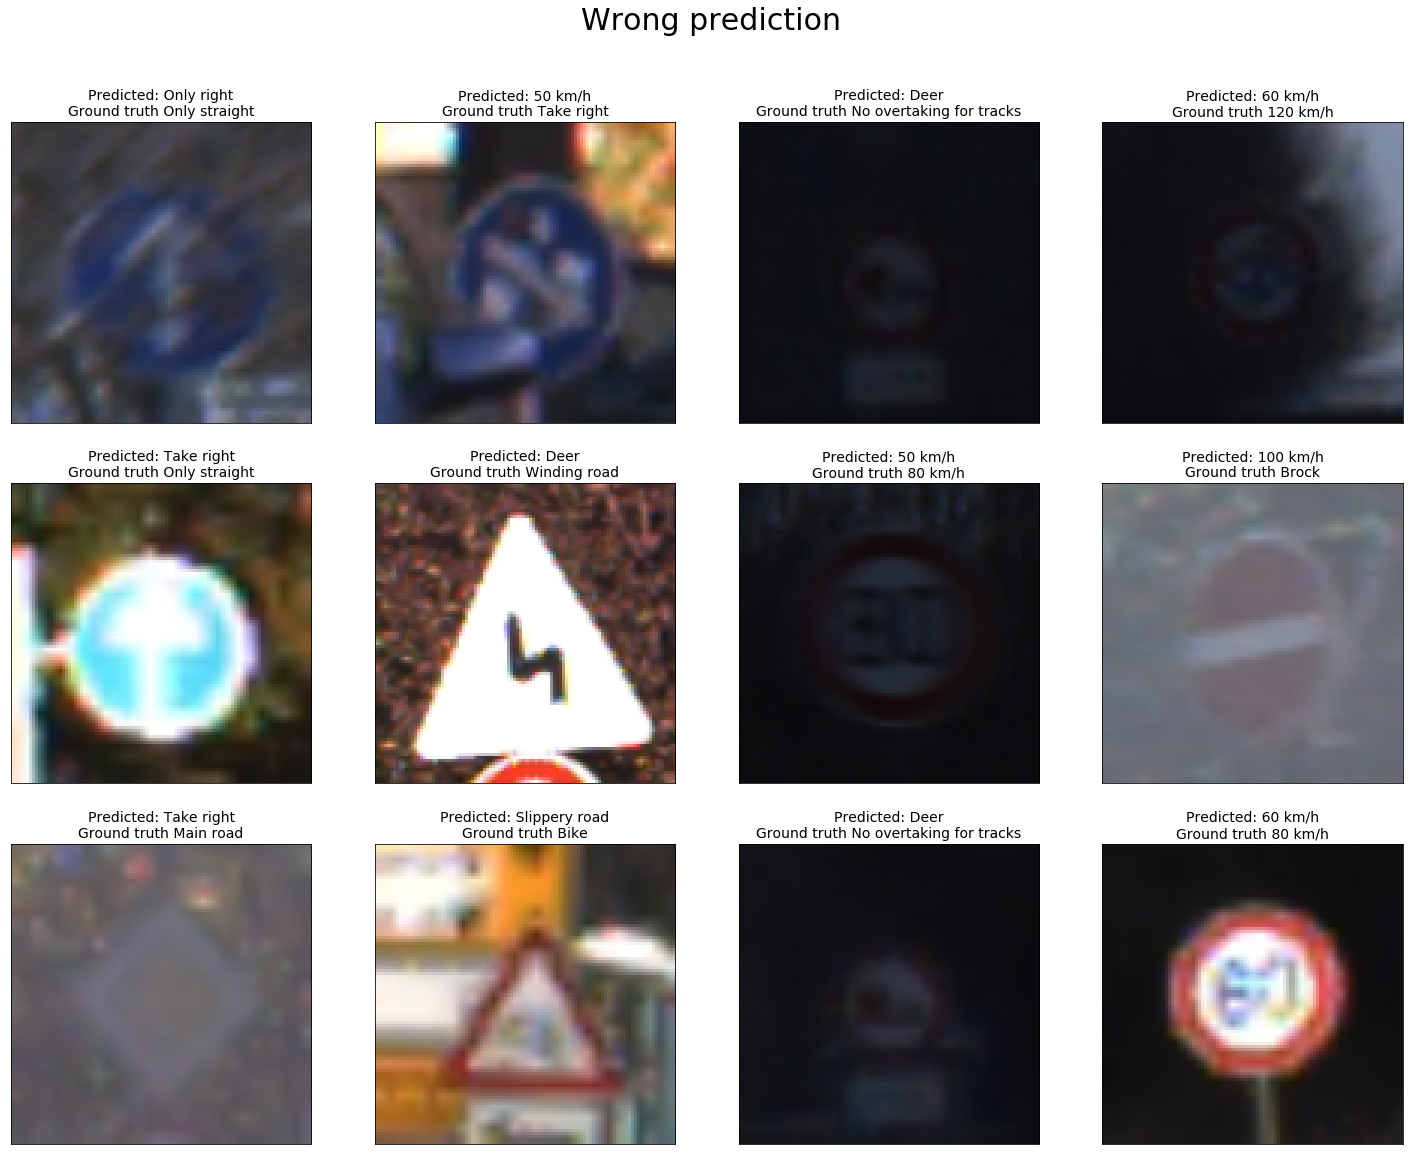

In [16]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 8))
visualize = trainDf.sample(rows*cols)

analys_df_copy = analys_df[analys_df['prediction_type'] == 'Wrong'].copy()
analys_df_copy = analys_df_copy.sample(frac=1)

idx = 0
for i in range(rows):
    for j in range(cols):
        img = cv2.imread(analys_df_copy.iloc[idx]['image'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100, 100))
        
        gt = analys_df_copy.iloc[idx]['gt']
        pred = analys_df_copy.iloc[idx]['prediction']
        
        axs[i,j].imshow(img)
        axs[i,j].set_title('Predicted: {}\nGround truth {}'.format(labels[pred], labels[gt]), fontsize=14)
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1
        
fig.suptitle("Wrong prediction", fontsize=30, y=2.1, x=0.515);
plt.subplots_adjust(left=None, bottom=None, right=0.9, top=1.9, wspace=None, hspace=None)

Let's dump all wrong prediction for further analys by someone else

In [17]:
output_dir = './output'
error_dir = './output/errors'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
if not os.path.isdir(error_dir):
    os.mkdir(error_dir)

for idx, row in tqdm.tqdm_notebook(analys_df[analys_df['prediction_type'] == 'Wrong'].iterrows()):
    name = os.path.splitext(os.path.basename(row['image']))[0]
    name = '{}__{}__as__{}.png'.format(name, labels[row['gt']].replace(' ', '_'), labels[row['prediction']].replace(' ', '_'))
    img = cv2.imread(row['image'])
    cv2.imwrite(os.path.join(error_dir, name), img)

And create tar archive for convenient way to download all at once

In [18]:
!tar -cvf ./errors.tar ./output/errors 1>/dev/null

系统找不到指定的路径。


### Confusion matrix

Confusion matrix gives us additional information about accuracy distribution. It's naturally that network may be confused in prediction 'Pedestrian' and 'Other dangerous' signs. Also, confusion matrix can give us idea what to improove in network

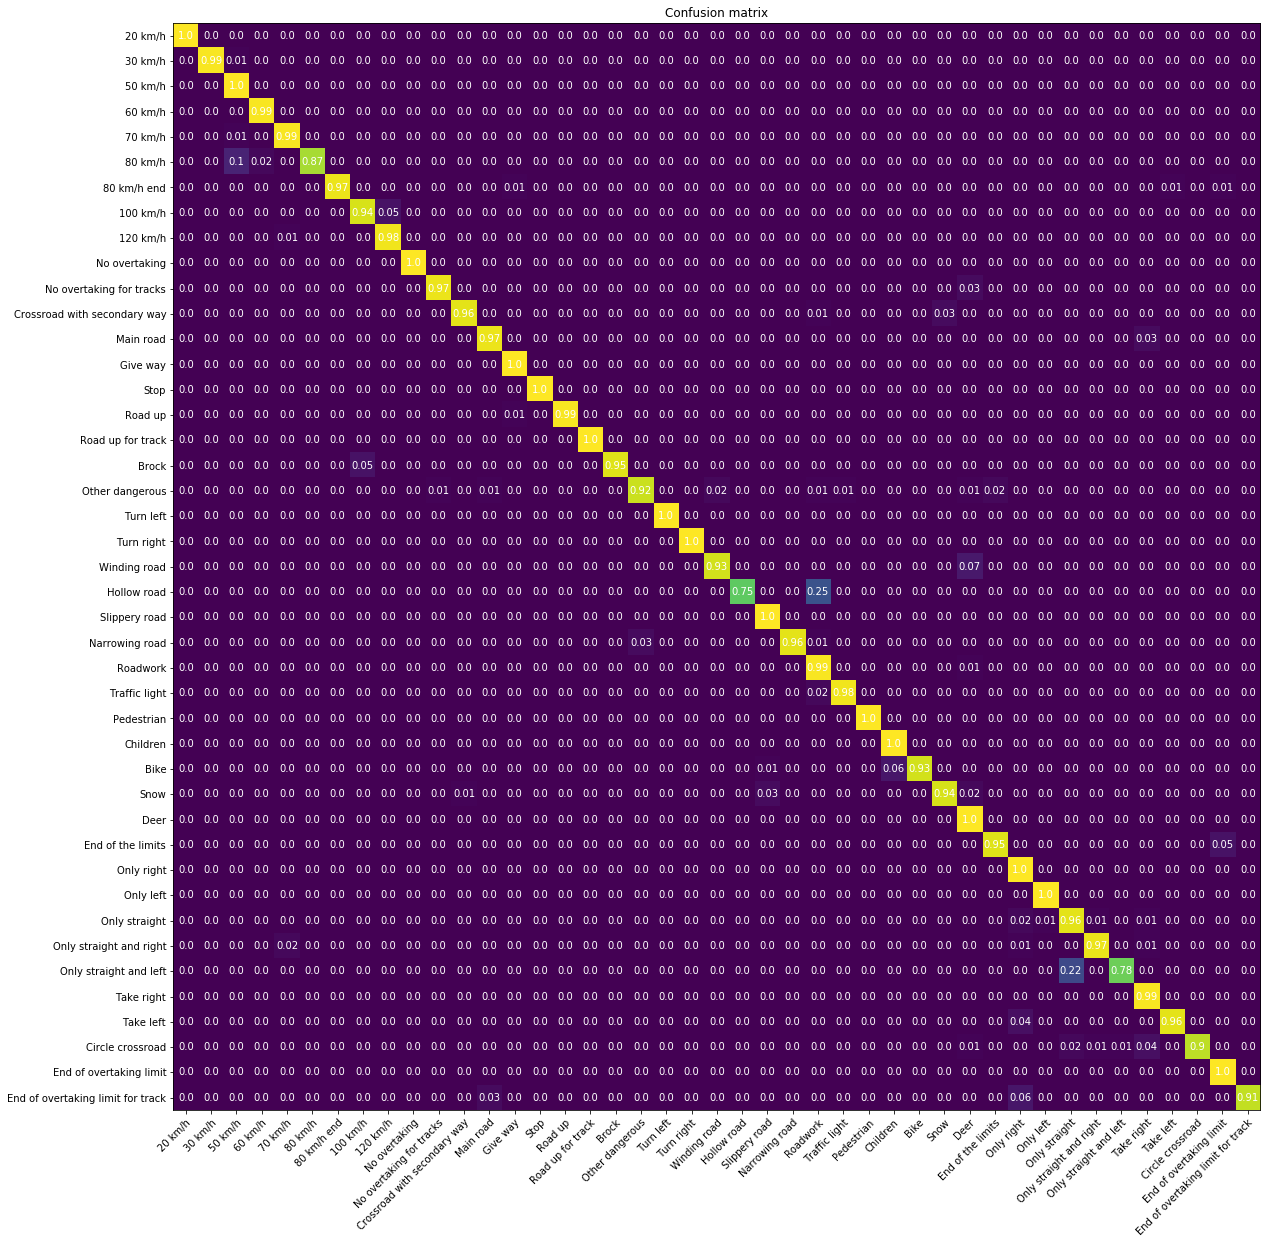

In [19]:
cm = confusion_matrix
f = np.sum(cm, axis=1)
normalized_cm = cm
for i in range(43):
    normalized_cm[i, :] /= sum(normalized_cm[i, :])

normalized_cm = np.round(normalized_cm, 2)
    
fig, ax = plt.subplots(1,1, figsize=((20, 20)))

ax.imshow(normalized_cm)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(labels)):
   for j in range(len(labels)):
       ax.text(j, i, normalized_cm[i, j], ha="center", va="center", color="w")

ax.set_title('Confusion matrix');

Here are histogram of prediction types

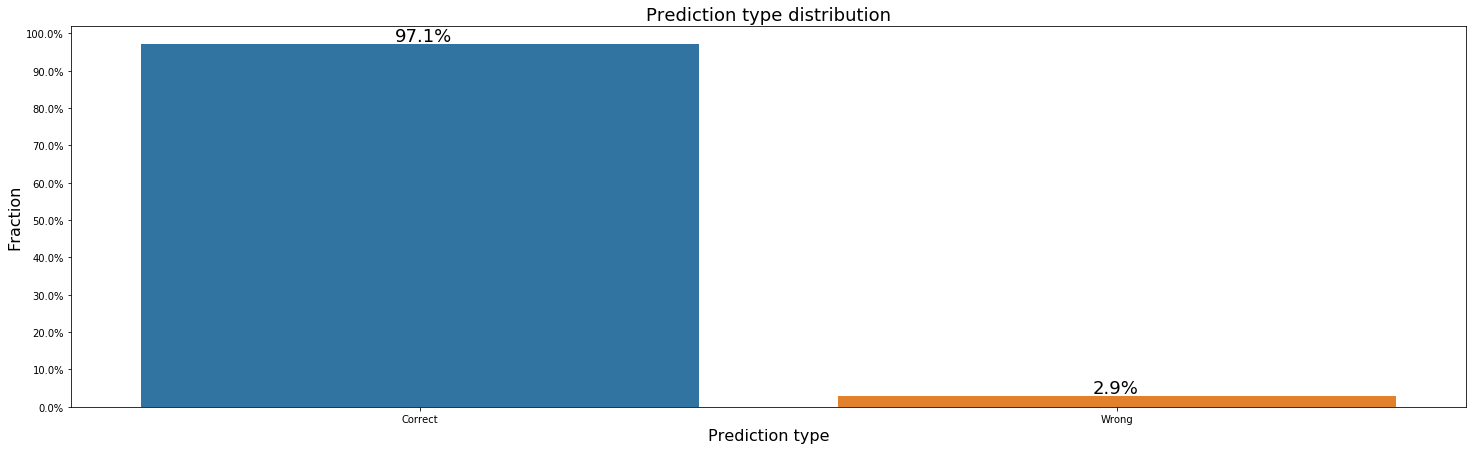

In [20]:
fig, axs = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(25, 7))

px = sns.countplot(x='prediction_type', data=analys_df, ax=axs)
axs.set_title('Prediction type distribution', fontsize=18)
axs.set_xlabel('Prediction type', fontsize=16)
axs.set_ylabel('Fraction', fontsize=16);


total = analys_df.shape[0]
for idx, p in enumerate(px.patches):
        px.annotate('{:.1f}%'.format(p.get_height()/total*100), (p.get_x()+0.365, p.get_height()+100), fontsize=18)


px.yaxis.set_ticks(np.linspace(0, total, 11))
px.set_yticklabels(map('{:.1f}%'.format, 100*px.yaxis.get_majorticklocs()/total));

In [21]:
analys_df.prediction_type.value_counts()

Correct    12252
Wrong        372
Name: prediction_type, dtype: int64

### Numerically accuracy by class
Confusion matrix produce perfect visualization for understanding why some class is so bad in predictions, but it's no so convenient way to sum up numerrically how this class is good predicted. Below are histgrams of corretly and wrong predicted classes without correlation with other classes

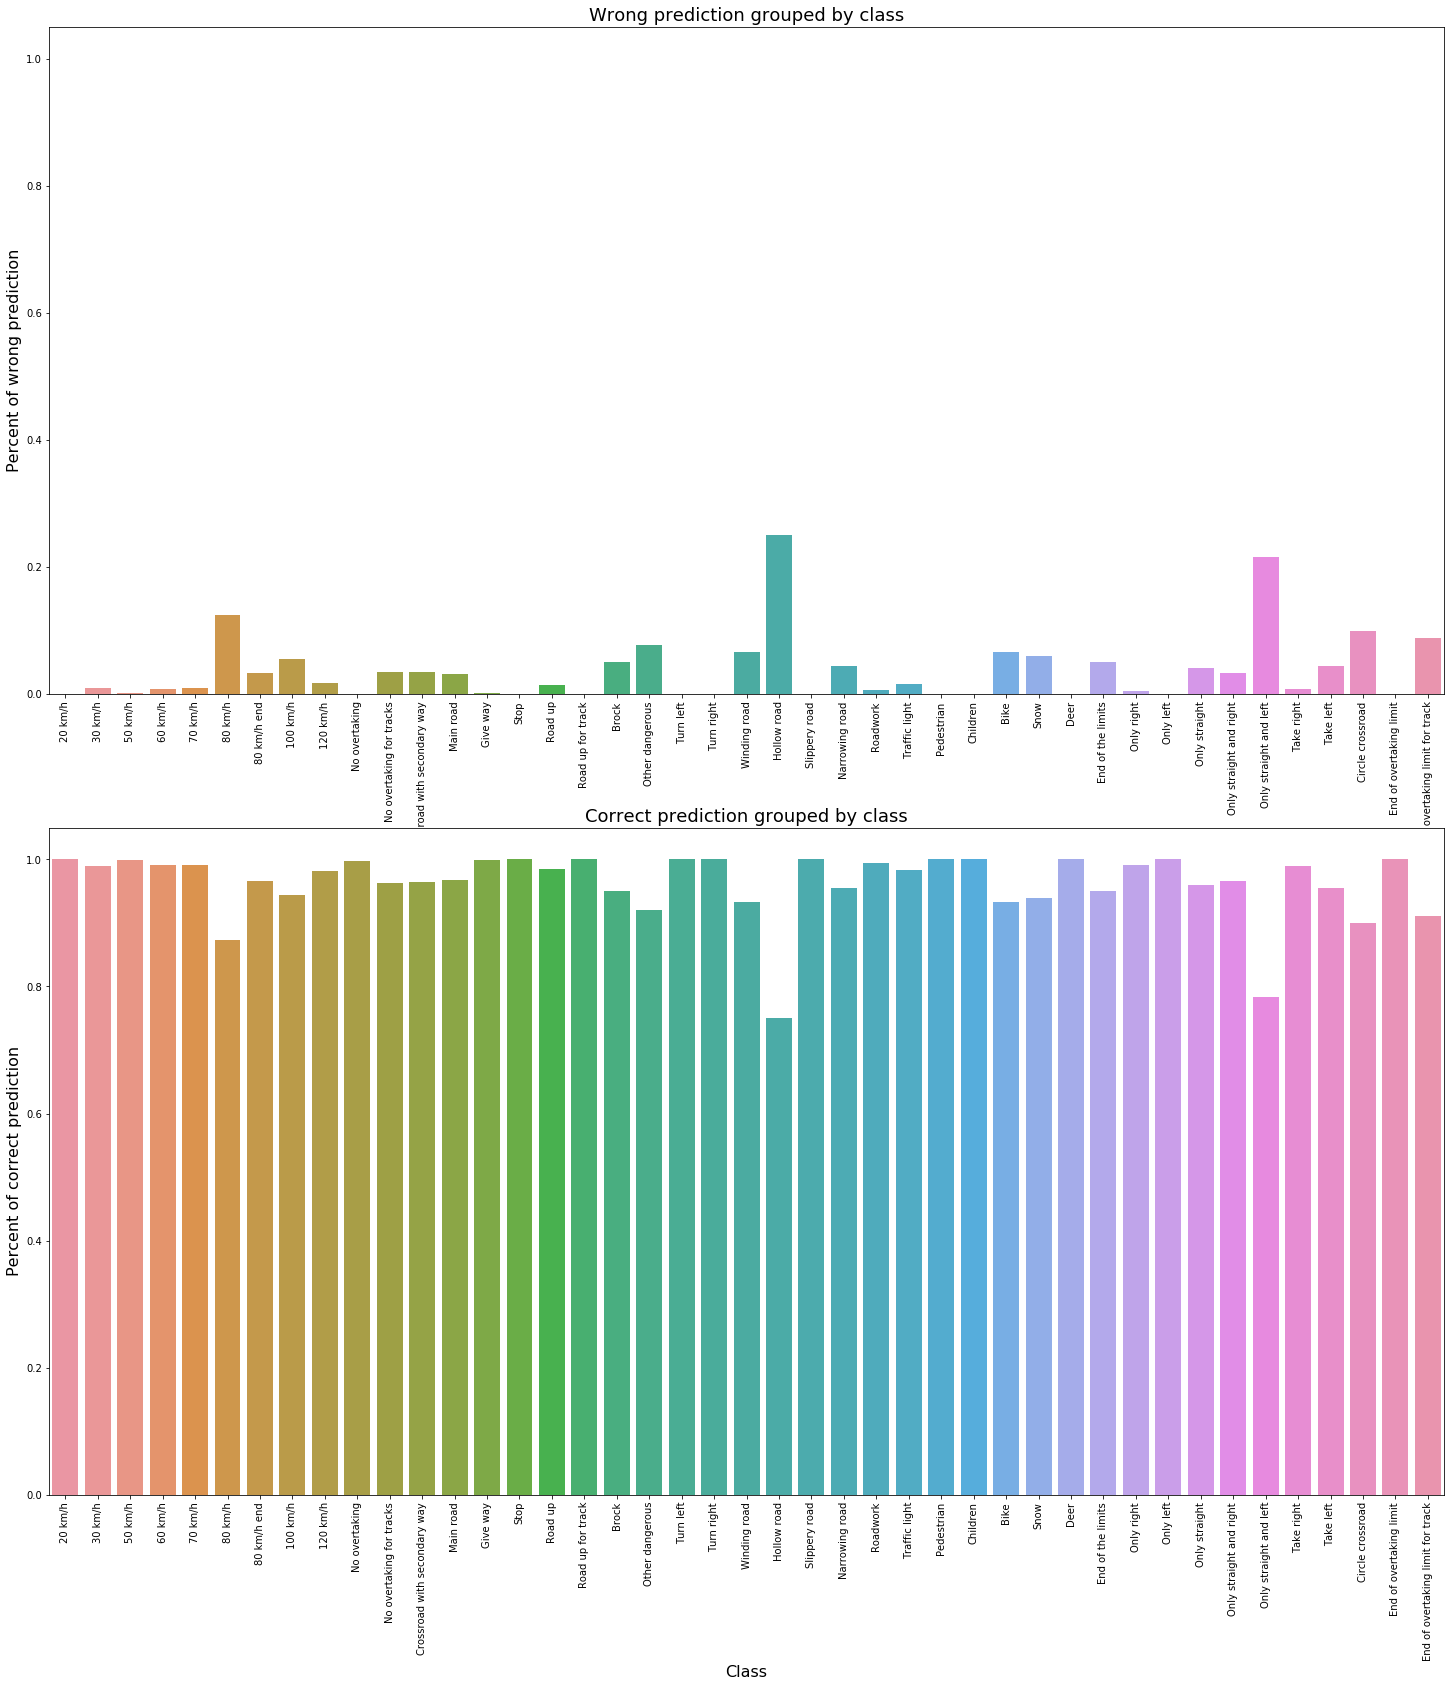

In [22]:
correct_prediction_by_class = analys_df[analys_df['prediction_type'] == 'Correct']['gt'].value_counts() / testDf['ClassId'].value_counts().sort_index()
correct_prediction_by_class_df = pd.DataFrame({'accuracy': correct_prediction_by_class, 'class': labels})

wrong_prediction_by_class = analys_df[analys_df['prediction_type'] == 'Wrong']['gt'].value_counts() / testDf['ClassId'].value_counts().sort_index()
wrong_prediction_by_class_df = pd.DataFrame({'error': wrong_prediction_by_class, 'class': labels})

fig, axs = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(25, 27))

sns.barplot(x='class', y='accuracy', data=correct_prediction_by_class_df, ax=axs[1])
sns.barplot(x='class', y='error', data=wrong_prediction_by_class_df, ax=axs[0])

axs[0].set_title('Wrong prediction grouped by class', fontsize=18)
axs[0].set_xlabel('Class', fontsize=16)
axs[0].set_ylabel('Percent of wrong prediction', fontsize=16)
axs[0].set_xticklabels(rotation=90, labels=labels)

axs[1].set_title('Correct prediction grouped by class', fontsize=18)
axs[1].set_xlabel('Class', fontsize=16)
axs[1].set_ylabel('Percent of correct prediction', fontsize=16)
axs[1].set_xticklabels(rotation=90, labels=labels);

### Confidence analysis

Classification neural networks produce not only discrete prediction. Model is also generated probability for each class (provided by softmax layer). Can we break up with wrong prediction by analys confidence levels?

Let's build confidence level distribution

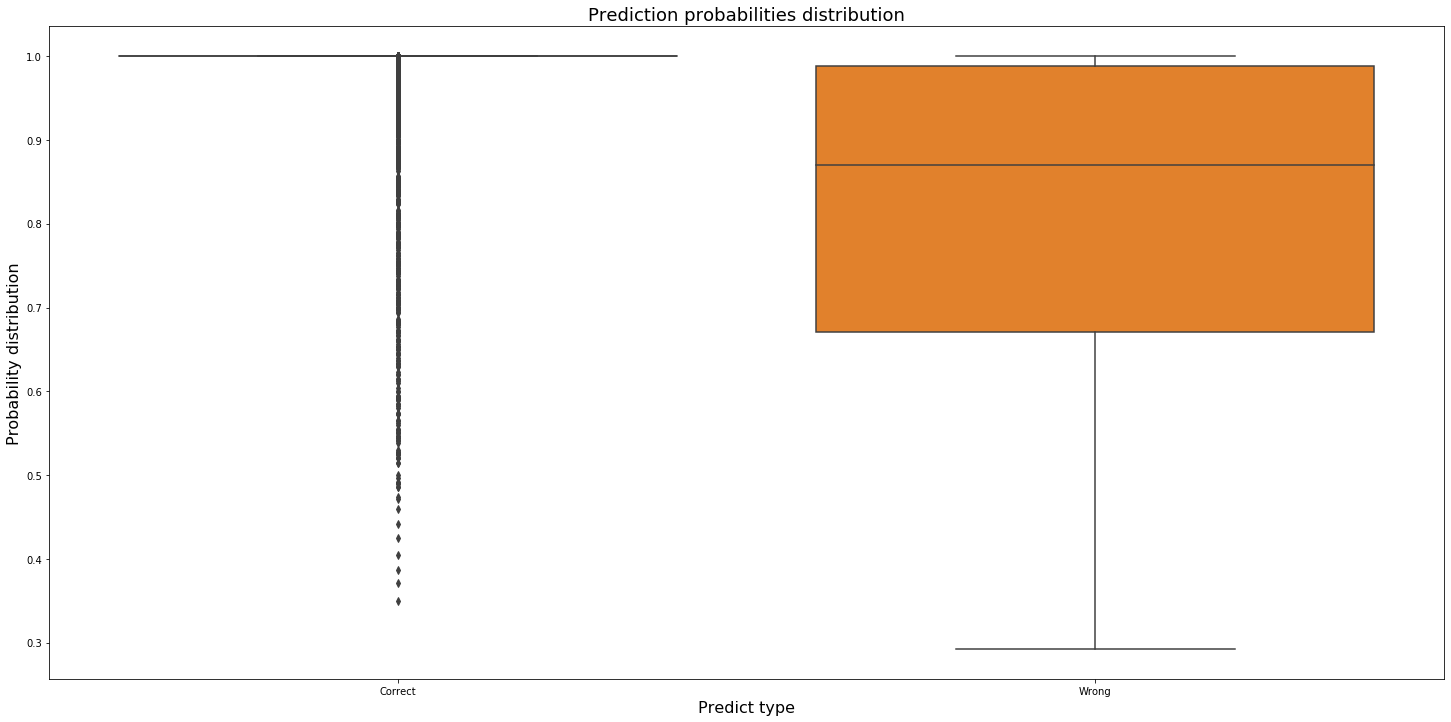

In [23]:
fig, axs = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(25,12))

sns.boxplot(x='prediction_type', y='prediction_probas', data=analys_df, ax=axs);
axs.set_title('Prediction probabilities distribution', fontsize=18);
axs.set_xlabel('Predict type', fontsize=16)
axs.set_ylabel('Probability distribution', fontsize=16);

### Confidence level threshold

Find threshold for confidence level by experiment. All predictions under this threshold will be threated as 'No shure'. It is clearly, that we can't achive more accuracy that we had before, but we can reduce wrong predictions

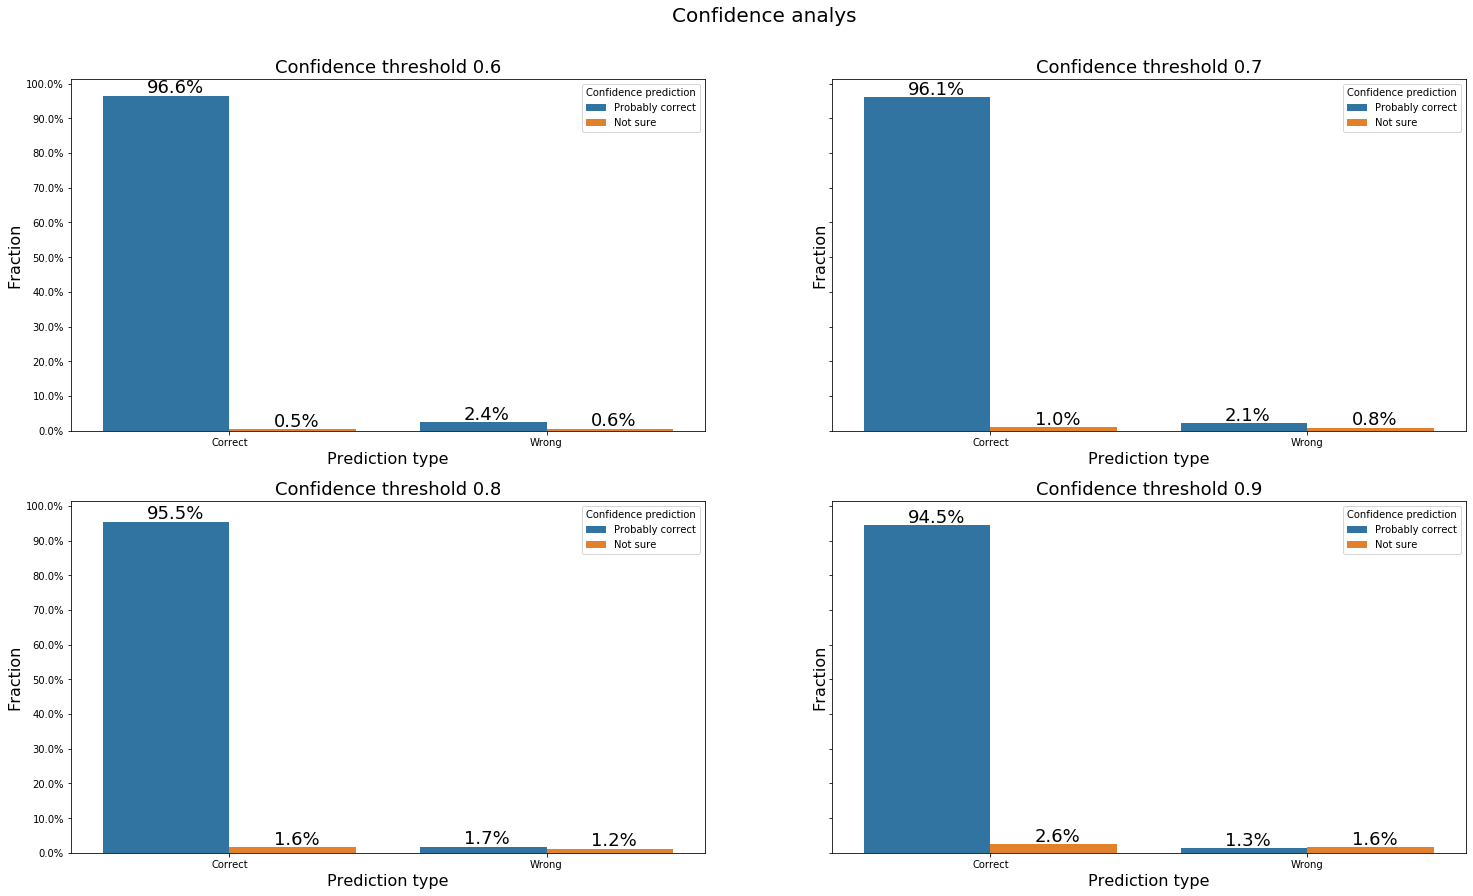

In [24]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=True, figsize=(25,10))

confidence_thresholds = iter([0.6, 0.7, 0.8, 0.9])

for i in range(2):
    for j in range(2):
        confidence_threshold = next(confidence_thresholds)
        
        analys_df_confidence = analys_df.copy()
        new_predict = []
        for idx, row in analys_df_confidence.iterrows():
            new_predict.append('Not sure' if row['prediction_probas'] < confidence_threshold else 'Probably correct')

        analys_df_confidence['confidence_analys'] = new_predict
        
        axs = axes[i,j]
        
        px = sns.countplot(x='prediction_type', hue='confidence_analys', data=analys_df_confidence, ax=axs);
        axs.set_title('Confidence threshold {}'.format(confidence_threshold), fontsize=18)
        axs.set_xlabel('Prediction type', fontsize=16)
        axs.set_ylabel('Fraction', fontsize=16);
        axs.legend(title='Confidence prediction')

        total = analys_df_confidence.shape[0]
        for idx, p in enumerate(px.patches):
            px.annotate('{:.1f}%'.format(p.get_height()/total*100), (p.get_x()+0.14, p.get_height()+100), fontsize=18)


        px.yaxis.set_ticks(np.linspace(0, total, 11))
        px.set_yticklabels(map('{:.1f}%'.format, 100*px.yaxis.get_majorticklocs()/total));

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.2, wspace=None, hspace=None)
fig.suptitle('Confidence analys', fontsize=20, y=1.3, x=0.51);

For more clearly answer, let's approximate function of confidence level threshold

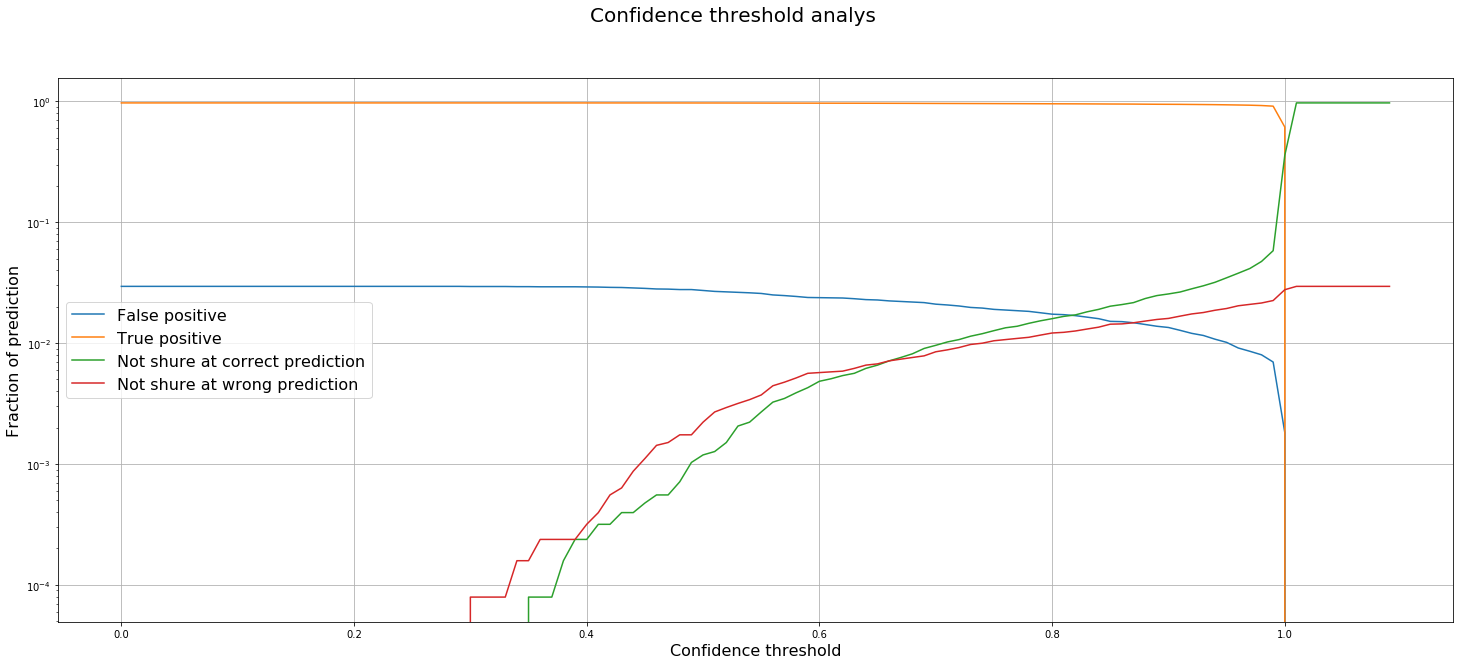

In [25]:
confidences = []

for confidence_threshold in tqdm.tqdm_notebook(np.arange(start=0, stop=1.1, step=0.01)):

    analys_df_confidence = analys_df.copy()
    new_predict = []
    for idx, row in analys_df_confidence.iterrows():
        new_predict.append('Not sure' if row['prediction_probas'] < confidence_threshold else 'Probably correct')

    analys_df_confidence['confidence_analys'] = new_predict

    false_positive = analys_df_confidence[(analys_df_confidence['prediction_type'] == 'Wrong') &
                                          (analys_df_confidence['confidence_analys'] == 'Probably correct')].shape[0]/analys_df_confidence.shape[0]
    
    true_positive = analys_df_confidence[(analys_df_confidence['prediction_type'] == 'Correct') &
                                          (analys_df_confidence['confidence_analys'] == 'Probably correct')].shape[0]/analys_df_confidence.shape[0]
    
    not_sure_at_wrong = analys_df_confidence[(analys_df_confidence['prediction_type'] == 'Wrong') &
                                          (analys_df_confidence['confidence_analys'] == 'Not sure')].shape[0]/analys_df_confidence.shape[0]
    
    not_sure_at_correct = analys_df_confidence[(analys_df_confidence['prediction_type'] == 'Correct') &
                                          (analys_df_confidence['confidence_analys'] == 'Not sure')].shape[0]/analys_df_confidence.shape[0]
    
    cf_level_result = {'fp': false_positive, 'tp': true_positive, 'ns_w': not_sure_at_wrong, 'ns_c': not_sure_at_correct, 'cf': confidence_threshold}
    confidences.append(cf_level_result)
    
confidences = pd.DataFrame(confidences)

fig, axes = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(25,10))


sns.lineplot(x='cf', y='fp', data=confidences, ax=axes, label='False positive');
sns.lineplot(x='cf', y='tp', data=confidences, ax=axes, label='True positive');
sns.lineplot(x='cf', y='ns_c', data=confidences, ax=axes, label='Not shure at correct prediction');
sns.lineplot(x='cf', y='ns_w', data=confidences, ax=axes, label='Not shure at wrong prediction');

axes.set_yscale('log')
axes.set_xlabel('Confidence threshold', fontsize=16)
axes.set_ylabel('Fraction of prediction', fontsize=16);
axes.legend(loc='center left', prop={'size': 16})
fig.suptitle('Confidence threshold analys', fontsize=20);
plt.grid()

### Convolution neural network visualization

There are many method for consolutional neural network visualization in many papers. The simplest one - visualize image after consolutional layer. We stores all results after each convolutional layers

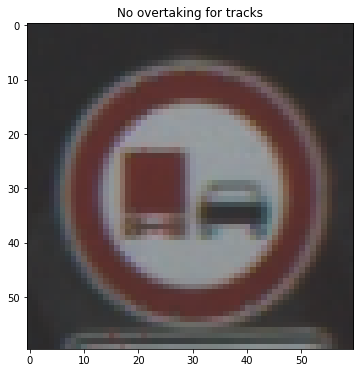

In [26]:
import matplotlib.gridspec as gridspec
res = sess.run([load_img, load_label, conv1, conv2, conv3, conv4, conv5, conv6],
               feed_dict={dp_rate: 0,
                          manual_load: False,
                          img_placeholder: np.zeros([12,60,60,3])})
img, label = res[0], res[1]
img_visible = (img*255).astype(np.uint8)[0, :, :, :]
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(img_visible)
ax.set_title(labels[label[0]])

filters = res[2:]
layer_names = ['Convolutional layer {}'.format(x+1) for x in range(len(filters))]

Convolutional layers have many filters. Visualizing all images is very epxencive and hard, but we will try. Results after convulition is not normalized, so we will normalized it manualy. Visualization looks like heatmap but it is not heatmap. It's just pretty visualization

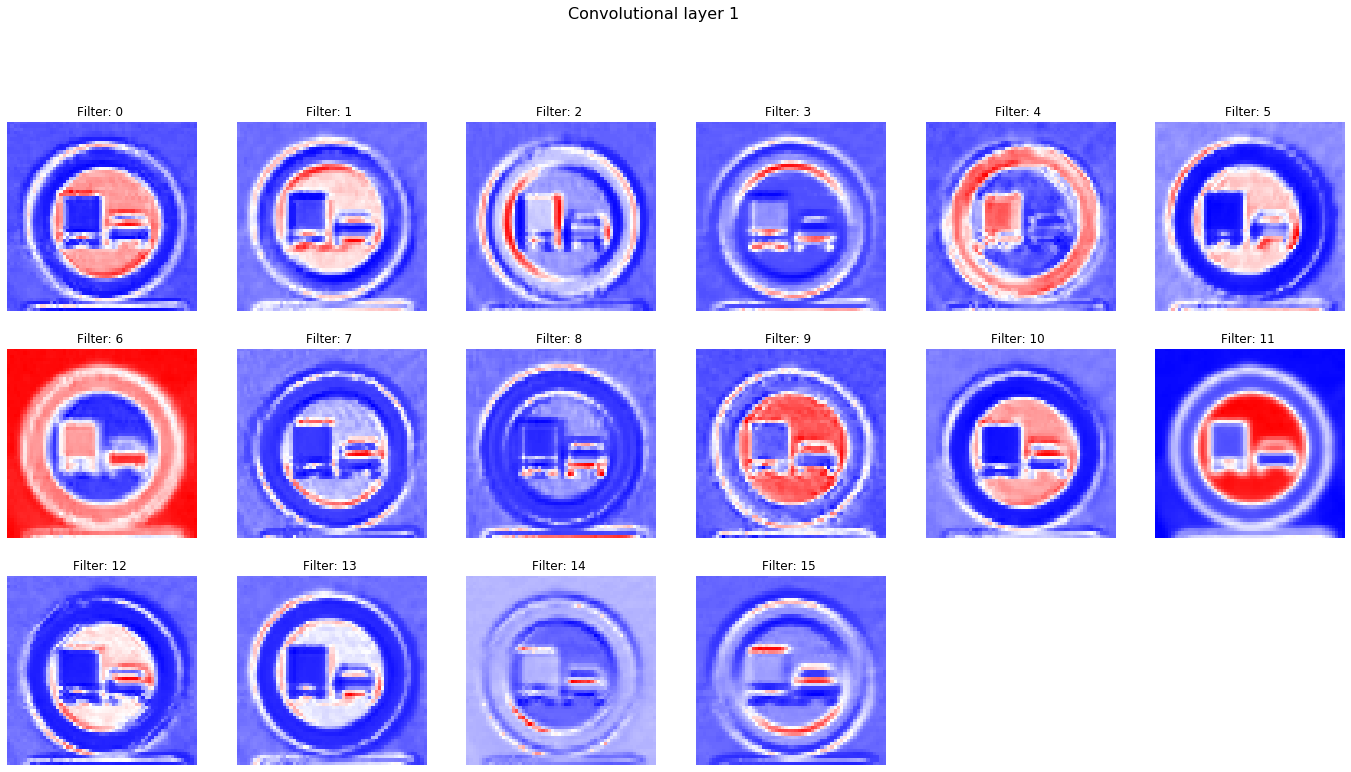

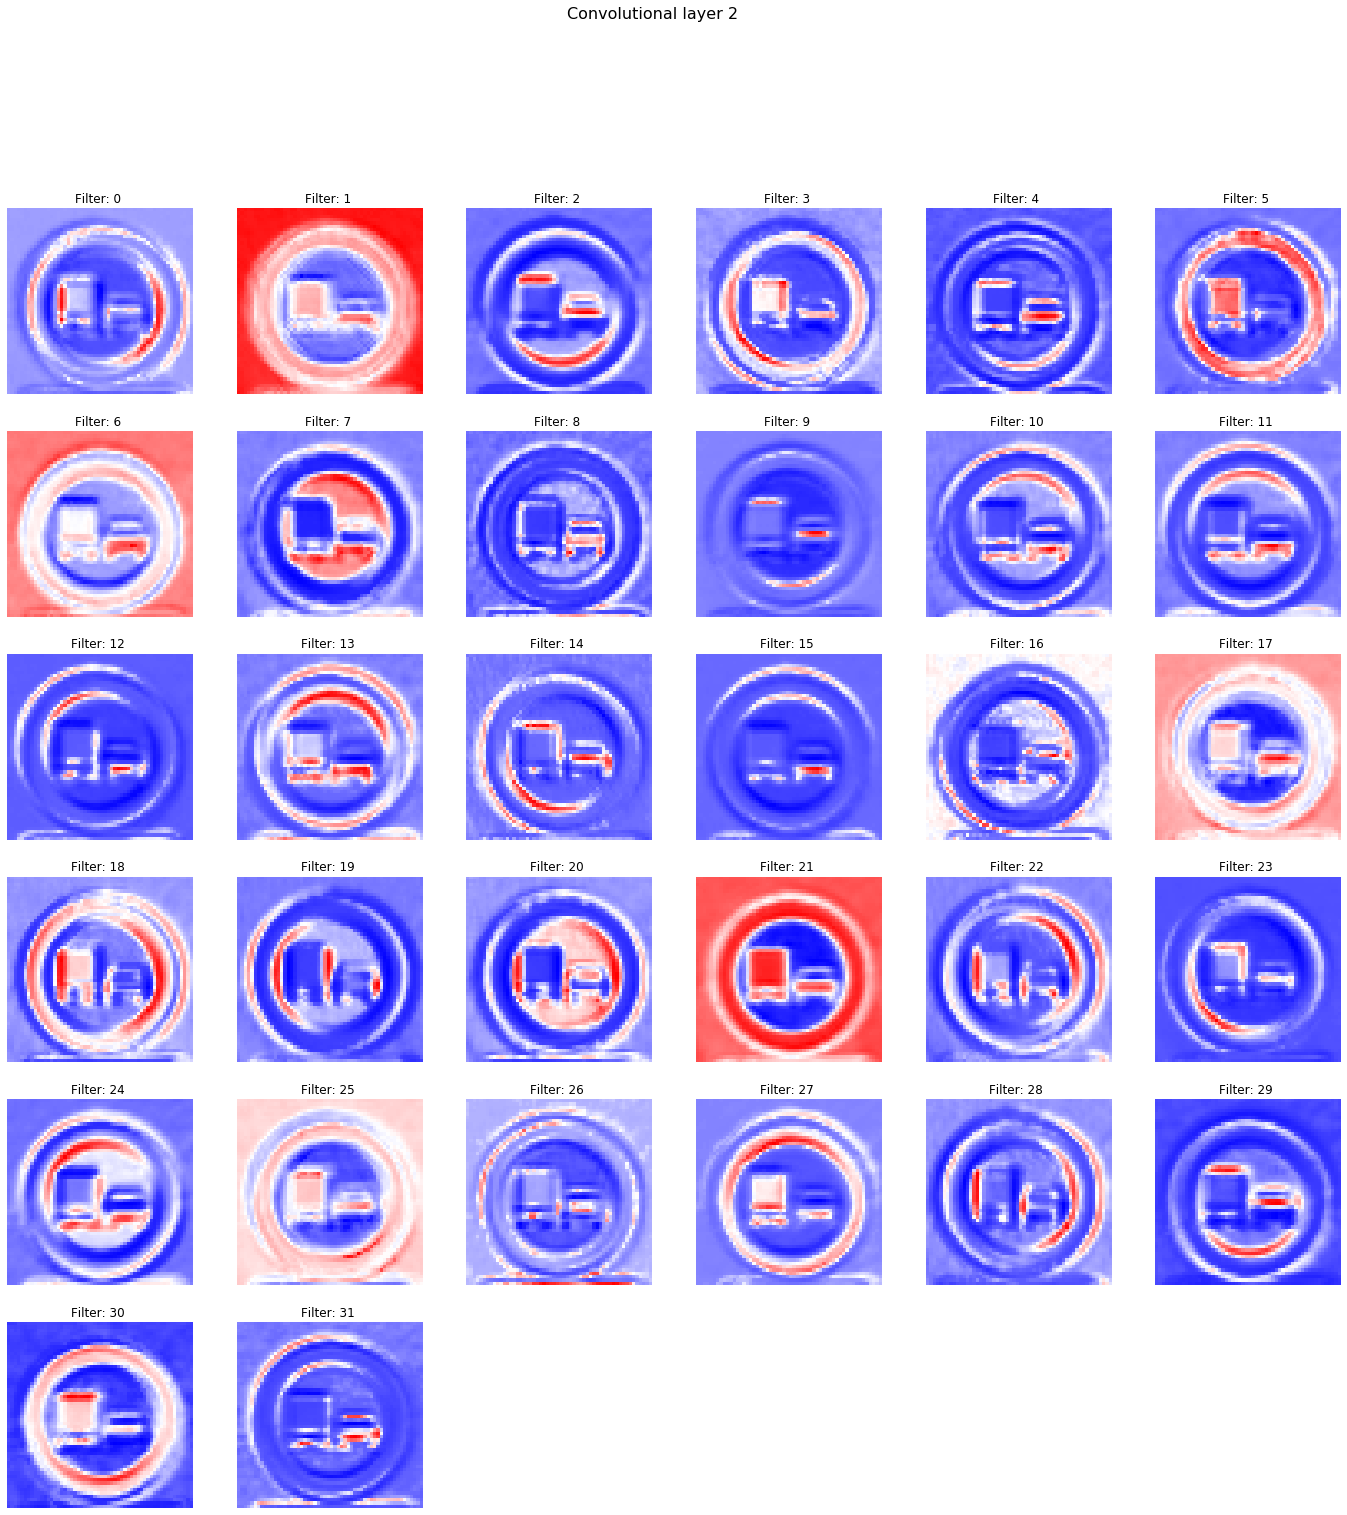

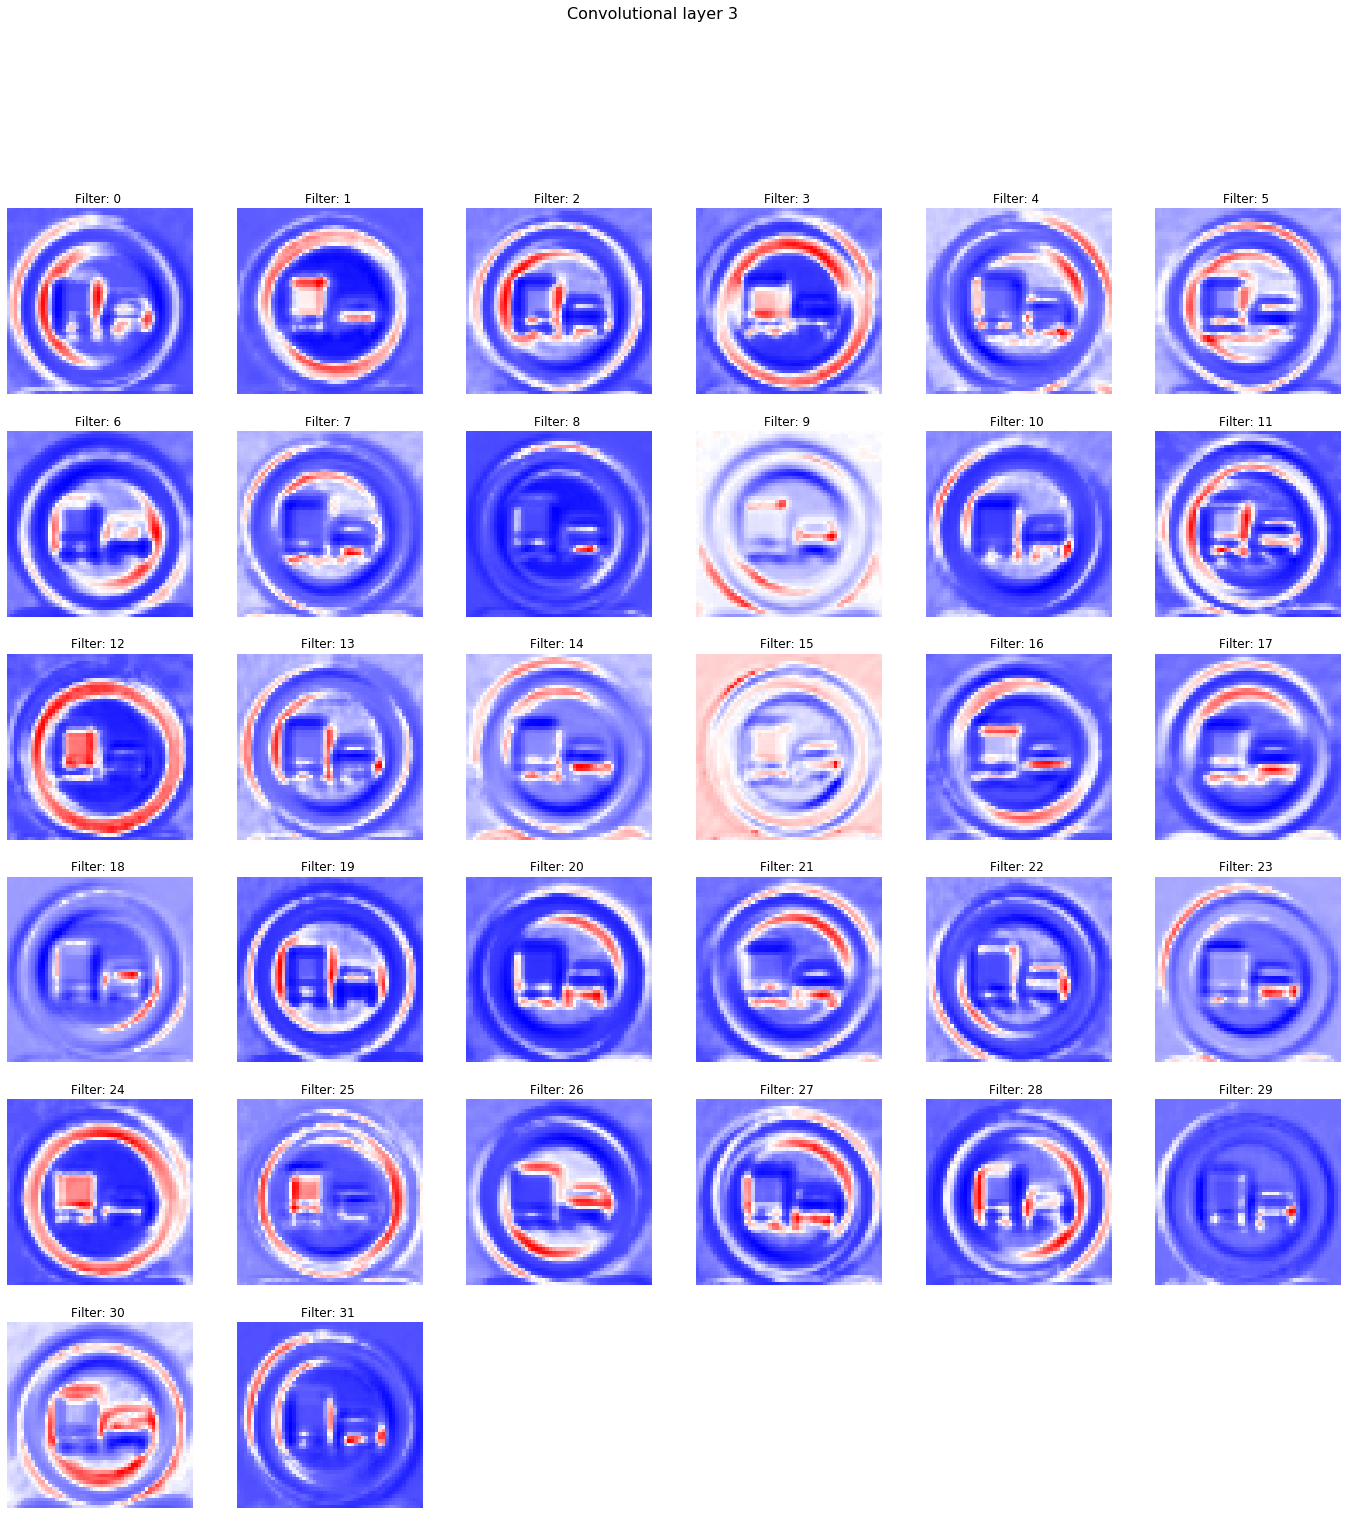

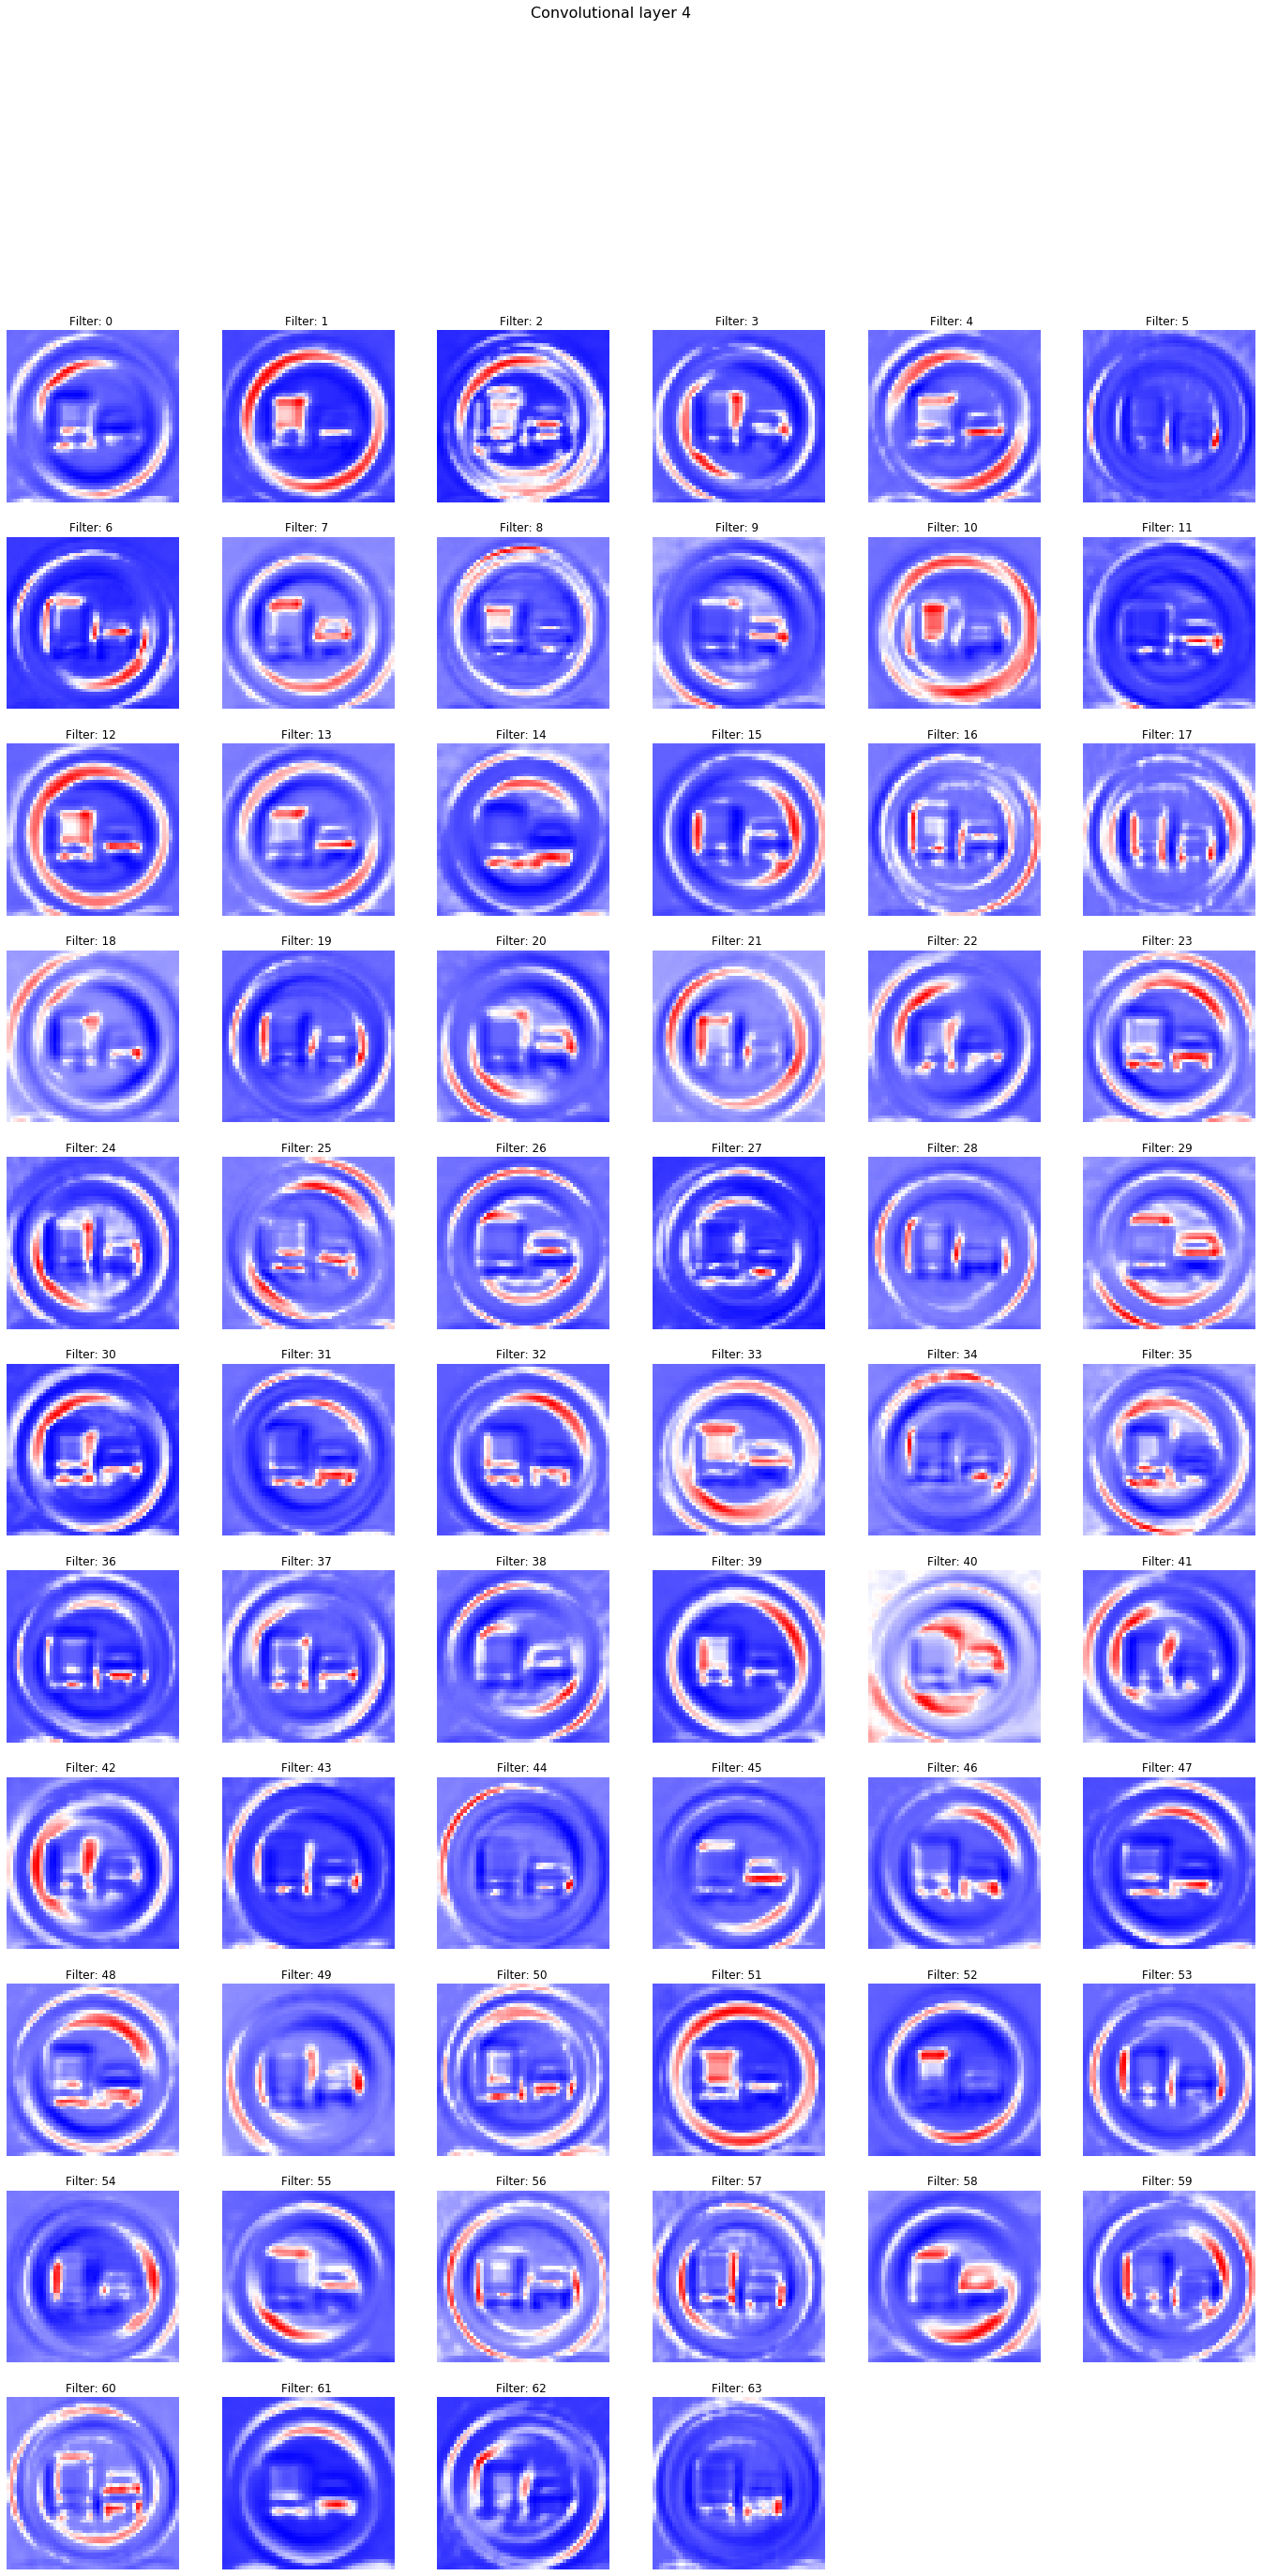

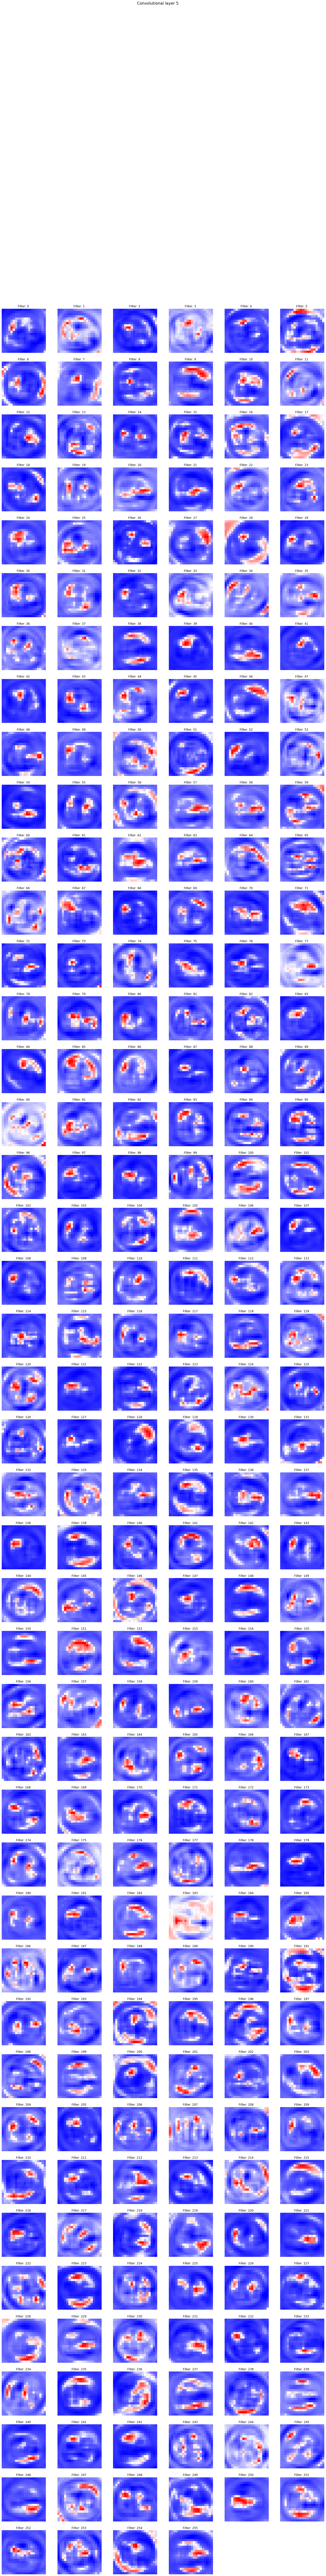

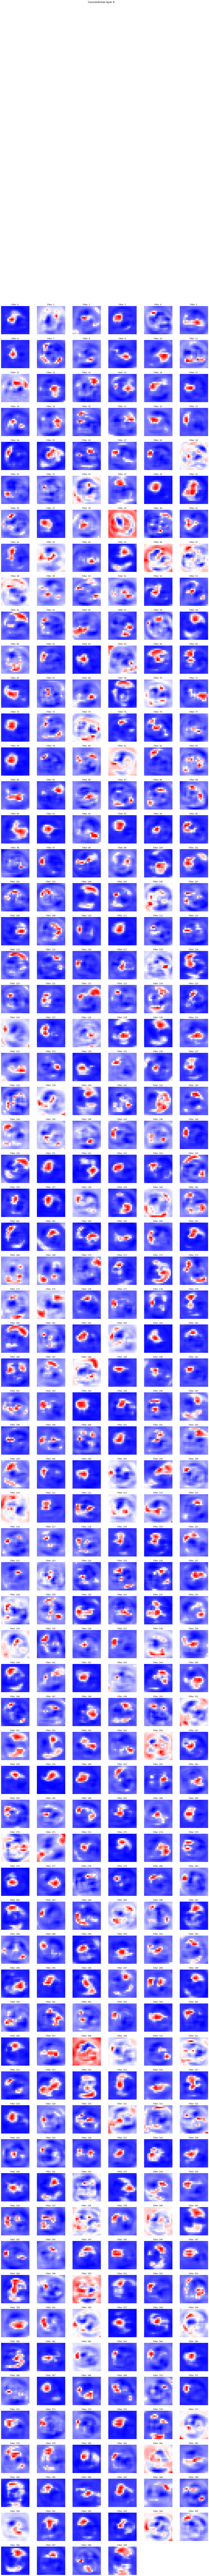

In [27]:
for filter_index in range(len(filters)):
    layers = filters[filter_index]
    filter_count = layers.shape[3]
    n_columns = 6
    n_rows = math.ceil(filter_count / n_columns) + 1
    fig = plt.figure(figsize=(24,n_rows*4));
    fig.suptitle(layer_names[filter_index], fontsize=16)
    for i in range(filter_count):
        plt.subplot(n_rows, n_columns, i+1)
        plt.axis('off')
        plt.title('Filter: {0} '.format(str(i)))
        plt.imshow(layers[0,:,:,i], interpolation="nearest", cmap='bwr')
    plt.show()

### Grad-CAM

Another good way to understand what our model have learned - using Grad-CAM method. [Grad-CAM](https://arxiv.org/abs/1610.02391) - is Gradient-weighted Class Activation Map. We can see which parts of image are important for prediction (i.e. mostly cause prediction).

In [28]:
def grad_cam(sess, layer, predicted_class, nb_classes, img):
    conv_layer = layer
    one_hot = tf.sparse_to_dense(predicted_class, [nb_classes], 1.0)
    signal = tf.multiply(logits, one_hot)
    loss = tf.reduce_mean(signal)
    
    grads = tf.gradients(loss, conv_layer)[0]
    # Normalizing the gradients
    norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads))) + tf.constant(1e-5))

    output, grads_val = sess.run([conv_layer, norm_grads], feed_dict={dp_rate: 0, manual_load: True,
                                                                     img_placeholder: img})
    output = output[0]           
    grads_val = grads_val[0]     

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    # Taking a weighted average
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    # Passing through ReLU
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, (224,224))

    # Converting grayscale to 3-D
    cam3 = np.expand_dims(cam, axis=2)
    cam3 = np.tile(cam3,[1,1,3])

    return cam3

Eveluate some samples and visualize Grad-CAM heatmaps

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


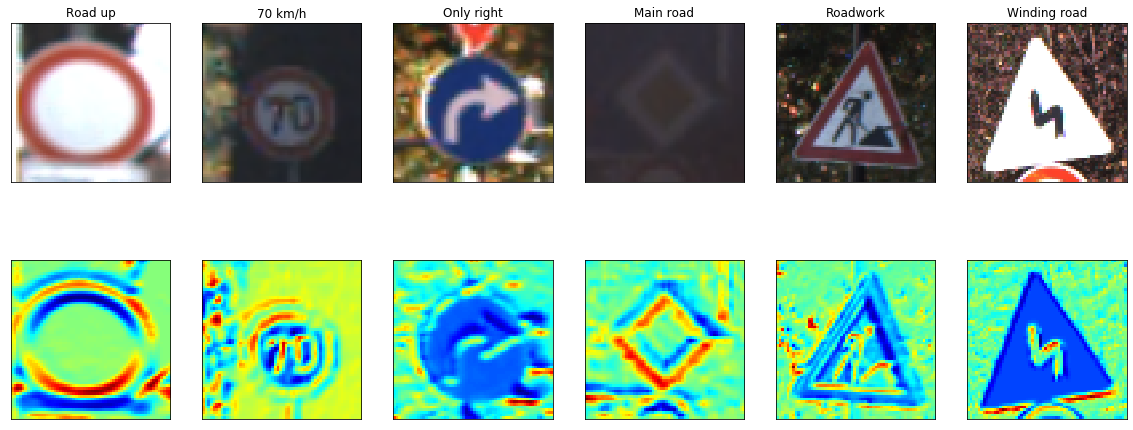

In [29]:
_img, _lb = sess.run([load_img, load_label])
grad_ipt = _img.copy()

samples = _img.shape[0]//2
fig, ax = plt.subplots(ncols=samples, nrows=2, figsize=(20, 8))
for i in range(samples):
    ax[0, i].imshow(_img[i, :, :, :])
    ax[0, i].get_xaxis().set_visible(False)
    ax[0, i].get_yaxis().set_visible(False)
    ax[0, i].set_title(labels[_lb[i]])
    
    image = _img[i, :, :, :]
    
    height = image.shape[0]
    width = image.shape[1]

    grad_ipt[0, :, :] = _img[i, :, :]
    heat_map = grad_cam(sess, conv1, _lb[i], 43, grad_ipt)
    # resize heat map
    heat_map_resized = cv2.resize(heat_map, (height, width))

    # normalize heat map
    max_value = np.max(heat_map_resized)
    min_value = np.min(heat_map_resized)
    normalized_heat_map = (heat_map_resized - min_value) / (max_value - min_value)
    normalized_heat_map = cv2.applyColorMap((normalized_heat_map*255).astype(np.uint8), cv2.COLORMAP_JET)
    
    ax[1, i].imshow(normalized_heat_map)
    ax[1, i].get_xaxis().set_visible(False)
    ax[1, i].get_yaxis().set_visible(False)